# Auswertung der Mobbing-Umfrage

Dieses Notebook dient der automatisierten Auswertung der Ergebnisse Ihrer Mobbing-Umfrage. Es verarbeitet die Daten aus der Datei `Ergebnisse.csv`, die Sie zuvor aus Tally exportiert haben.

## Funktionsweise

1. **Datenimport**: Das Notebook liest die CSV-Datei ein und bereitet die Daten für die Analyse vor.
2. **Datenanalyse**: Es werden Muster und Trends im Antwortverhalten der Schülerinnen und Schüler untersucht.
3. **Visualisierung**: Die Ergebnisse werden durch anschauliche Diagramme und Grafiken dargestellt.
4. **Berichtserstellung**: Abschließend wird ein umfassender PDF-Bericht generiert, der alle wichtigen Erkenntnisse zusammenfasst.

## Anleitung

_Achtung_: Werfen Sie vor dem Start einen Blick in die Tabelle, um bspw. Namen in Antworten zu anonymisieren. Stellen Sie sicher, dass die Datei als Trennzeichen "Komma" verwendet.

Um die Auswertung zu starten, führen Sie "Run All" aus. Sie werden aufgefordert, den Autorennamen, das SJ, das Berichtsdatum und die Anzahl aller SchülerInnen einzugeben. Etwas weiter unten werden Sie gebeten, die Datei `Ergebnisse.csv` hochzuladen. Daraufhin können Sie außerdem den PDF-Bericht des Vorjahres sowie die Ergebnisse einer Meta-Umfrage hochladen, um Vergleiche zu ermöglichen.


In [29]:
#@title Input Author Name and Student Count
from datetime import datetime

# Determine school year based on current date
current_year = datetime.now().year
if datetime.now().month >= 7:  # If it's July or later
    school_year = f"{current_year}/{current_year + 1}"
else:  # If it's before July
    school_year = f"{current_year - 1}/{current_year}"


author_name = input("Bitte geben Sie den Autorennanmen ein, der auf dem Bericht erscheinen soll, oder drücken Sie Enter für keinen Autor: ") or " "
school_year = input(f"Bitte geben Sie das aktuelle Schuljahr ein, oder drücken Sie Enter für das ermittelte aktuelle Schuljahr {school_year}: ") or school_year
date_today = input(f"Bitte geben Sie das Datum des Berichts ein, oder drücken Sie Enter für das heutige Datum {datetime.now().strftime('%d.%m.%Y')}: ") or datetime.now().strftime('%d.%m.%Y')
student_count = int(input("Bitte geben Sie die Gesamtanzahl der Schüler*innen in Ihrer Schule ein, oder drücken Sie Enter für keine Angabe: ") or 0)

In [30]:
#@title Datei-Upload: Ergebnisse.csv

import os
import time
import sys
from IPython.display import clear_output, display, Javascript
import ipywidgets as widgets


# 1. Check: Are we running in Colab?
try:
    import google.colab
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 2. File check & upload logic
required_file = 'Ergebnisse.csv'

# Ensure we define specific anchor for the title if you want to jump to the top
# You can add a markdown cell above this code with: # <a id="upload_section"></a>
# Then use: display(Javascript('document.getElementById("upload_section").scrollIntoView()'))

if not os.path.exists(required_file):
    print(f"⚠️ Datei '{required_file}' fehlt!")
    
    # --- CASE A: Google Colab ---
    if IN_COLAB:
        print("Bitte laden Sie die Datei jetzt hoch (Dialog öffnet sich unten):")
        
        uploaded = files.upload() # Pauses the script until upload is complete
        
        for fn in uploaded.keys():
            if fn != required_file:
                os.rename(fn, required_file)
                print(f"Datei wurde in '{required_file}' umbenannt.")

In [31]:
#@title Datei-Upload: Ergebnisse.csv (Fortsetzung)

if not os.path.exists(required_file):
    if not IN_COLAB:
        print("Lokalmodus erkannt.")
        print(f"Bitte legen Sie die Datei '{required_file}' in denselben Ordner wie dieses Notebook.")
        
        # Optional: An upload button for local use (requires ipywidgets)
        print("Alternativ: Datei hier auswählen:")
        uploader = widgets.FileUpload(accept='.csv', multiple=False)
        display(uploader)
        
        # Wait for manual user action (loop)
        print("Warte auf Datei...")
        while not os.path.exists(required_file):
            # Check if widget was used
            if uploader.value:
                # Save file from widget
                # (Syntax for ipywidgets >= 8.0)
                if isinstance(uploader.value, tuple): # Old version
                     content = uploader.value[0]['content']
                     filename = uploader.value[0]['name']
                else: # New version (more likely in VSCode)
                     vals = list(uploader.value) # Gets the first element
                     content = vals[0]['content']
                     filename = vals[0]['name']

                with open(required_file, 'wb') as f:
                    f.write(content)
                print(f"Upload via Widget erfolgreich: {filename}")
                break
                
            time.sleep(1) # Wait briefly to save CPU

    clear_output()
    print(f"✅ Datei '{required_file}' gefunden. Analyse läuft weiter...")

else:
    print(f"✅ Datei '{required_file}' bereits vorhanden. Gehe weiter...")

✅ Datei 'Ergebnisse.csv' bereits vorhanden. Gehe weiter...


In [32]:
#@title Historische Daten aus alten Berichten laden

import glob
import json
import pandas as pd
import os


history_data = []

if IN_COLAB:
    print("--- 📤 Upload Vorjahres-Bericht ---")
    print("Bitte laden Sie den PDF-Bericht des LETZTEN Jahres hoch.")
    print("(Da dieser alle vorherigen Jahre enthält, reicht die aktuellste Datei.)")
    print("Falls dies das allererste Jahr ist: Einfach abbrechen / nichts hochladen.")
    uploaded_pdfs = files.upload()
else:
    print("Lokale Umgebung erkannt. Suche nach PDF-Dateien im aktuellen Ordner...")

# 2. Alle PDFs verarbeiten
pdf_files = glob.glob("*.pdf")

for pdf_file in pdf_files:
    try:
        with open(pdf_file, 'rb') as f:
            content = f.read()
            # Wir suchen das LETZTE gültige JSON-Objekt am Ende der Datei (letzte 250 kB)
            search_window = content[-250000:]
            parts = search_window.split(b'\n')
            
            found_json = False
            for part in reversed(parts):
                if not part.strip(): continue
                try:
                    data = json.loads(part)
                    
                    # A) Es ist eine Liste (Das ist ein Master-Archiv)
                    if isinstance(data, list):
                        # Logik: Wir nehmen immer das Archiv, das am MEISTEN Jahre enthält.
                        if len(data) > len(history_data):
                            history_data = data
                            print(f"✅ Master-Archiv geladen aus: {pdf_file} (Enthält {len(data)} Jahre)")
                        found_json = True
                        break
                    
                except json.JSONDecodeError:
                    continue
            
    except Exception as e:
        print(f"⚠️ Fehler beim Lesen von {pdf_file}: {e}")

# WICHTIG: Nach Schuljahr sortieren
history_data.sort(key=lambda x: x['meta']['school_year'])

if history_data:
    # Wir nehmen das letzte Jahr aus der Historie, um dem User zu zeigen, wo wir stehen
    latest_year = history_data[-1]['meta']['school_year']
    print(f"\n📈 Historie erfolgreich eingelesen!")
    print(f"   Stand: {len(history_data)} Datensätze vorhanden.")
    print(f"   Letztes vorhandenes Jahr: {latest_year}")
else:
    print("\nℹ️ Keine historischen Daten gefunden. (Start bei Null)")

Lokale Umgebung erkannt. Suche nach PDF-Dateien im aktuellen Ordner...

ℹ️ Keine historischen Daten gefunden. (Start bei Null)


In [33]:
#@title Datei-Upload: Feedback.csv (Optional)
required_feedback_file = 'Feedback.csv'

if not os.path.exists(required_feedback_file):
    if IN_COLAB:
        print("Optional: Laden Sie 'Feedback.csv' hoch, falls vorhanden.")
        print("Falls nicht, wird dieser Teil im Bericht übersprungen.")
        uploaded_fb = files.upload()
        for fn in uploaded_fb.keys():
            if fn != required_feedback_file:
                os.rename(fn, required_feedback_file)
    else:
        print(f"Lokalmodus: Suche nach '{required_feedback_file}'...")

if os.path.exists(required_feedback_file):
    print("✅ Feedback-Daten gefunden. Werden in Anhang C integriert.")
    has_feedback = True
    df_feedback = pd.read_csv(required_feedback_file)
else:
    print("ℹ️ Keine Feedback-Daten. Anhang C wird ausgeblendet.")
    has_feedback = False

✅ Feedback-Daten gefunden. Werden in Anhang C integriert.


In [34]:
#@title Installation of Dependencies (Colab vs. Local)

import os
import shutil


if IN_COLAB:
    print("Colab detected. Installing system dependencies (Pandoc, XeTeX)...")
    # Run shell commands using the ! magic syntax
    # The print statement must be on a new line, not appended to the shell command
    !sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1 || (echo "Paketlisten veraltet, führe Update durch..." && sudo apt-get update -qq && sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null)
    print("System dependencies installed.")

else:
    print("Local environment detected. Please ensure Pandoc and XeTeX are installed manually if needed.")

# 3. Check if pypandoc (Python lib) is missing
try:
    import pypandoc
    print("pypandoc already installed.")
except ImportError:
    print("Installing pypandoc...")
    %pip install pypandoc

try:
    import tabulate
    print("tabulate already installed.")
except ImportError:
    print("Installing tabulate...")
    %pip install tabulate

try:
    import seaborn as sns
    print("seaborn already installed.")
except ImportError:
    print("Installing seaborn...")
    %pip install seaborn

try:
    import matplotlib.pyplot as plt
    print("matplotlib already installed.")
except ImportError:
    print("Installing matplotlib...")
    %pip install matplotlib

try:
    import matplotlib_venn
    print("matplotlib-venn already installed.")
except ImportError:
    print("Installing matplotlib-venn...")
    %pip install matplotlib-venn


if os.path.exists("img"):
    shutil.rmtree("img")  # Remove the directory and all its contents
os.makedirs("img", exist_ok=True)  # Recreate the directory

Local environment detected. Please ensure Pandoc and XeTeX are installed manually if needed.
pypandoc already installed.
tabulate already installed.
seaborn already installed.
matplotlib already installed.
matplotlib-venn already installed.


In [35]:
#@title Import Results CSV

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('Ergebnisse.csv')

In [36]:
#@title Datenbereinigung: Unplausible Antworten markieren

import pandas as pd
import numpy as np

def clean_survey_data(df):
    """
    Markiert unplausible Antworten vorsichtig.
    Löscht keine Daten, sondern fügt eine Spalte 'is_suspicious' und 'suspicion_reason' hinzu.
    """
    
    # 1. Mapping der Text-Antworten in Zahlen für die Analyse
    # Frequenz-Skalen (Fragen 15, 18, 21) [cite: 66-75]
    freq_map = {
        'Nie': 0,
        'Selten': 1,
        'Monatlich': 2,
        'Wöchentlich': 3,
        'Mehrmals pro Woche': 4,
        'Täglich': 5
    }
    
    # Likert-Skalen sind im CSV meist schon 1-5, falls nicht, hier mappen.
    # Wir gehen davon aus, dass Likert-Fragen (Q3-14, Q36-39) numerisch 1-5 vorliegen.
    
    # Arbeitskopie erstellen
    df_check = df.copy()
    
    # Frequenz-Spalten umwandeln (Q15=Physisch, Q18=Verbal, Q21=Cyber)
    violence_cols = ['Q15', 'Q18', 'Q21']
    for col in violence_cols:
        if col in df_check.columns:
            df_check[f'{col}_num'] = df_check[col].map(freq_map).fillna(0)

    # ---------------------------------------------------------
    # FILTER 1: Extremes Straight-Lining (Konservativ)
    # ---------------------------------------------------------
    # Wir prüfen nur die Matrix-Fragen zum Klima/Lehrer/Familie (Likert 1-5)
    # Fragen 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 36, 37, 38, 39
    likert_cols = [
        'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 
        'Q11', 'Q12', 'Q13', 'Q14', 'Q36', 'Q37', 'Q38', 'Q39'
    ]
    
    # Nur Spalten nutzen, die auch im Datensatz existieren
    existing_likert = [c for c in likert_cols if c in df_check.columns]
    
    suspicious_indices = []
    reasons = {}

    if existing_likert:
        # Berechne Standardabweichung pro Zeile
        std_devs = df_check[existing_likert].std(axis=1)
        
        # Kriterium: Standardabweichung ist exakt 0 (hat überall exakt das gleiche geklickt)
        # UND es wurden mehr als 5 Fragen beantwortet (um NaNs abzufangen)
        count_answers = df_check[existing_likert].count(axis=1)
        
        straight_liners = df_check[(std_devs == 0) & (count_answers > 10)].index
        
        for idx in straight_liners:
            suspicious_indices.append(idx)
            reasons[idx] = "Straight-Lining (Identische Antwort überall)"

    # ---------------------------------------------------------
    # FILTER 2: Harter Logik-Widerspruch (Sicherheit vs. Gewalt)
    # ---------------------------------------------------------
    # Logik: Wer Q6 (Sicher) mit 5 bewertet, aber Q15 (Physische Gewalt) mit >= 4 (oft)
    
    if 'Q6' in df_check.columns and 'Q15_num' in df_check.columns:
        # Q6 = 5 ("Stimmt voll und ganz") 
        # Q15_num >= 4 ("Mehrmals pro Woche" oder "Täglich") [cite: 74, 75]
        contradiction = df_check[
            (df_check['Q6'] == 5) & 
            (df_check['Q15_num'] >= 4)
        ].index
        
        for idx in contradiction:
            suspicious_indices.append(idx)
            current_reason = reasons.get(idx, "")
            new_reason = "Widerspruch: Fühlt sich sicher (5) aber tägliche Gewalt"
            reasons[idx] = (current_reason + "; " + new_reason).strip("; ")

    # ---------------------------------------------------------
    # Ergebnis zusammenfügen
    # ---------------------------------------------------------
    df['is_suspicious'] = False
    df['suspicion_reason'] = ""
    
    # Markiere die gefundenen Indizes
    if suspicious_indices:
        df.loc[suspicious_indices, 'is_suspicious'] = True
        # Setze die Gründe
        for idx, reason in reasons.items():
            df.loc[idx, 'suspicion_reason'] = reason

    return df

# --- Beispiel zur Nutzung ---
# Angenommen, 'data' ist dein DataFrame aus der CSV/Excel
# cleaned_data = clean_survey_data(data)

# Filtern (optional, wenn du sie rauswerfen willst):
# final_data = cleaned_data[cleaned_data['is_suspicious'] == False]

df = clean_survey_data(df)

# Print number of suspicious entries found
num_suspicious = df['is_suspicious'].sum()

df = df[df['is_suspicious'] == False]

In [37]:
#@title Survey Format
survey = [
    {
      "short_id": "Submitted at",
      "long_question": "Timestamp",
      "type": "datetime"
    },
    {
      "short_id": "class_level",
      "long_question": "In welcher Klasse bist du?",
      "type": "single_choice",
      "options": [
        "5. Klasse",
        "6. Klasse",
        "7. Klasse",
        "8. Klasse",
        "9. Klasse",
        "10. Klasse",
        "11. Klasse",
        "12. Klasse"
      ]
    },
    {
      "short_id": "gender",
      "long_question": "Wie bezeichnest du dein Geschlecht?",
      "type": "single_choice",
      "options": [
        "weiblich",
        "männlich",
        "divers"
      ]
    },
    {
      "short_id": "friends_in_class",
      "long_question": "In meiner Klasse habe ich enge FreundInnen, auf die ich mich verlassen kann.",
      "type": "likert",

    },
    {
      "short_id": "respect_in_class",
      "long_question": "In meiner Klasse gehen wir höflich und respektvoll miteinander um.",
      "type": "likert",

    },
    {
      "short_id": "liked_by_others",
      "long_question": "Ich habe das Gefühl, dass die anderen in der Klasse es mögen, wenn ich dabei bin.",
      "type": "likert",

    },
    {
      "short_id": "safety_in_class",
      "long_question": "Ich fühle mich in meiner Klasse sicher.",
      "type": "likert",

    },
    {
      "short_id": "like_school",
      "long_question": "Ich gehe gerne zur Schule.",
      "type": "likert",

    },
    {
      "short_id": "teacher_fairness",
      "long_question": "Ich habe das Gefühl, dass die meisten Lehrkräfte uns SchülerInnen gerecht behandeln.",
      "type": "likert",

    },
    {
      "short_id": "teacher_trust",
      "long_question": "Es gibt Lehrkräfte in der Schule, denen ich vertrauen kann.",
      "type": "likert",

    },
    {
      "short_id": "teacher_care",
      "long_question": "Ich habe das Gefühl, dass die Lehrkräfte meine Sorgen ernst nehmen.",
      "type": "likert",

    },
    {
      "short_id": "adult_listener_home",
      "long_question": "Zu Hause gibt es mindestens eine erwachsene Person, die mir zuhört, wenn es mir nicht gut geht.",
      "type": "likert",

    },
    {
      "short_id": "family_acceptance",
      "long_question": "In meiner Familie habe ich das Gefühl, so akzeptiert zu werden, wie ich bin.",
      "type": "likert",

    },
    {
      "short_id": "friends_outside_school",
      "long_question": "Ich habe mindestens eine gute Freundin oder einen guten Freund außerhalb meiner Klasse, der/dem ich vertraue.",
      "type": "likert",

    },
    {
      "short_id": "reliable_people_general",
      "long_question": "Insgesamt habe ich das Gefühl, dass ich Menschen habe, auf die ich mich wirklich verlassen kann.",
      "type": "likert",

    },
    {
      "short_id": "physical_violence_freq",
      "long_question": "Wie oft wurdest du in den letzten 6 Monaten Opfer von körperlicher Gewalt von MitschülerInnen (z. B. Schubsen, Schlagen, Treten)",
      "type": "single_choice",
      "options": [
        "Nie",
        "Selten",
        "Monatlich",
        "Wöchentlich",
        "Mehrmals pro Woche",
        "Täglich"
      ]
    },
    {
      "short_id": "physical_violence_type",
      "long_question": "In welcher Form ist das passiert? (Körperliche Gewalt)",
      "type": "multiple_choice",
      "options": [
        { "short_id": "hit_kicked", "long": "Ich wurde geschlagen oder getreten." },
        { "short_id": "threatened", "long": "Ich wurde bedroht (z. B. mit Schlägen oder Gegenständen)." },
        { "short_id": "restrained", "long": "Man hat mich festgehalten oder am Weggehen gehindert." },
        { "short_id": "property_damage", "long": "MitschülerInnen haben meine Sachen beschädigt oder versteckt." },
        { "short_id": "extortion", "long": "Ich wurde erpresst." },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "physical_violence_duration",
      "long_question": "Seit wann passiert das? (Körperliche Gewalt)",
      "type": "single_choice",
      "options": [
        "Mehr als 2 Jahre",
        "1-2 Jahre",
        "6-12 Monate",
        "3-6 Monate",
        "1-3 Monate",
        "Weniger als 1 Monat"
      ]
    },
    {
      "short_id": "verbal_violence_freq",
      "long_question": "Wie oft wurdest du in den letzten 6 Monaten Opfer von verbaler oder sozialer Gewalt von MitschülerInnen? (z. B. Beschimpfungen, Ausgrenzen, Gerüchte)",
      "type": "single_choice",
      "options": [
        "Nie",
        "Selten",
        "Monatlich",
        "Wöchentlich",
        "Mehrmals pro Woche",
        "Täglich"
      ]
    },
    {
      "short_id": "verbal_violence_type",
      "long_question": "In welcher Form ist das passiert? (Verbale/Soziale Gewalt)",
      "type": "multiple_choice",
      "options": [
        { "short_id": "insults", "long": "Beleidigungen oder Schimpfwörter" },
        { "short_id": "nicknames", "long": "Gemeine Spitznamen" },
        { "short_id": "mockery", "long": "Ausgelacht oder verspottet werden" },
        { "short_id": "rumors", "long": "Gerüchte oder Lügen verbreitet" },
        { "short_id": "exclusion", "long": "Ignoriert oder bewusst ausgeschlossen werden" },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "verbal_violence_duration",
      "long_question": "Seit wann passiert das? (Verbale/Soziale Gewalt)",
      "type": "single_choice",
      "options": [
        "Mehr als 2 Jahre",
        "1-2 Jahre",
        "6-12 Monate",
        "3-6 Monate",
        "1-3 Monate",
        "Weniger als 1 Monat"
      ]
    },
    {
      "short_id": "cyberbullying_freq",
      "long_question": "Wie oft wurdest du in den letzten 6 Monaten Opfer von Cybermobbing von MitschülerInnen (z. B. Beleidigungen, Bloßstellung oder Bedrohung online)",
      "type": "single_choice",
      "options": [
        "Nie",
        "Selten",
        "Monatlich",
        "Wöchentlich",
        "Mehrmals pro Woche",
        "Täglich"
      ]
    },
    {
      "short_id": "cyberbullying_type",
      "long_question": "In welcher Form ist das passiert? (Cybermobbing)",
      "type": "multiple_choice",
      "options": [
        { "short_id": "insults_chat", "long": "Beleidigungen per Chat oder Kommentar" },
        { "short_id": "rumors_online", "long": "Gerüchte oder Lügen über mich wurden online verbreitet" },
        { "short_id": "embarrassing_media", "long": "Peinliche Fotos/Videos von mir wurden veröffentlicht" },
        { "short_id": "threats_online", "long": "Bedrohung oder Erpressung per Chat/SMS/Web" },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "victim_confirmation_check",
      "long_question": "Nein, ich war in den letzten 6 Monaten *kein* Opfer von körperlicher oder verbaler Gewalt oder Cybermobbing",
      "type": "checkbox",
      "options": []
    },
    {
      "short_id": "perpetrator_count",
      "long_question": "Wie viele Personen waren an diesen Handlungen von körperlicher Gewalt, verbaler Gewalt oder Cybermobbing gegen dich meistens beteiligt?",
      "type": "single_choice",
      "options": [
        "Eine Person",
        "Zwei bis vier Personen",
        "Mehr als vier Personen",
        "Mehr als die Hälfte einer Klasse"
      ]
    },
    {
      "short_id": "perpetrators_classmate",
      "long_question": "Sind diese Personen aus deiner Klasse?",
      "type": "single_choice",
      "options": [
        "Ja",
        "Nein"
      ]
    },
    {
      "short_id": "defense_reaction",
      "long_question": "Wie wehrst du dich gegen körperliche oder andere Formen von Gewalt / Cybermobbing?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "physical", "long": "Körperlich (Zurückschlagen, Prügel)" },
        { "short_id": "verbal", "long": "Verbal (Beleidigungen, Rufe)" },
        { "short_id": "friends", "long": "Ich hole FreundInnen." },
        { "short_id": "teachers", "long": "Ich hole LehrerInnen." },
        { "short_id": "withdrawal", "long": "Ich ziehe mich zurück/ gehe weg." },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "observed_bullying_freq",
      "long_question": "Wie oft hast du Mobbing an anderen MitschülerInnen beobachtet?",
      "type": "single_choice",
      "options": [
        "Nie",
        "Selten",
        "Monatlich",
        "Wöchentlich",
        "Mehrmals pro Woche",
        "Täglich"
      ]
    },
    {
      "short_id": "bullying_location",
      "long_question": "Wo passieren Übergriffe oder Mobbing / wo siehst du sie?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "none_observed", "long": "Ich habe keine Übergriffe beobachtet" },
        { "short_id": "classroom", "long": "Klassenzimmer" },
        { "short_id": "schoolyard", "long": "Schulhof" },
        { "short_id": "hallway", "long": "Treppenhaus/Flur" },
        { "short_id": "restrooms", "long": "Toiletten" },
        { "short_id": "way_to_school", "long": "Schulweg" },
        { "short_id": "online", "long": "Online" },
        { "short_id": "elsewhere", "long": "Anderswo" }
      ]
    },
    {
      "short_id": "bullying_time",
      "long_question": "Wann passieren solche Übergriffe / wann siehst du sie?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "during_class", "long": "Während des Unterrichts" },
        { "short_id": "during_breaks", "long": "In den Pausen" },
        { "short_id": "before_after_school", "long": "Vor oder nach der Schule" }
      ]
    },
    {
      "short_id": "intervention_willingness",
      "long_question": "Wenn du sehen würdest, dass jemand gemobbt wird, würdest du selbst eingreifen oder helfen?",
      "type": "likert",
      "options": ["1 (Gar nicht) bis 5 (Auf jeden Fall)"]
    },
    {
      "short_id": "observer_feelings",
      "long_question": "Wenn du Mobbing beobachtest, was fühlst oder denkst du dabei?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "disapproval", "long": "„Das ist nicht in Ordnung.“" },
        { "short_id": "fear_of_retaliation", "long": "„Das Opfer tut mir leid, aber ich habe Angst, selbst gemobbt zu werden.“" },
        { "short_id": "helplessness", "long": "„Ich würde gerne helfen, weiß aber nicht wie.“" },
        { "short_id": "support_side", "long": "„Ich will eine der beiden Seiten unterstützen.“" },
        { "short_id": "indifference", "long": "„Es ist mir egal.“" },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "past_reaction_observation",
      "long_question": "Wie hast du in der Vergangenheit reagiert, wenn du Mobbing gesehen hast?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "joined_in", "long": "Ich habe beim Mobben mitgemacht." },
        { "short_id": "looked_away", "long": "Ich habe weggeschaut, um Ärger zu vermeiden." },
        { "short_id": "watched_passively", "long": "Ich habe zugeschaut, ohne einzugreifen." },
        { "short_id": "got_help", "long": "Ich habe eine andere Person dazugeholt." },
        { "short_id": "helped_directly", "long": "Ich habe versucht, dem Opfer direkt zu helfen." },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "knows_help_contact",
      "long_question": "Ich weiß, an wen ich mich wenden kann, wenn ich gemobbt werde oder Probleme in der Klasse habe.",
      "type": "binary",
      "options": [
        "Ja",
        "Nein"
      ]
    },
    {
      "short_id": "preferred_help_contact",
      "long_question": "An wen würdest du dich wenden?",
      "type": "multiple_choice",
      "options": [
        { "short_id": "counselor", "long": "VertrauenslehrerIn" },
        { "short_id": "class_teacher", "long": "KlassenlehrerIn" },
        { "short_id": "friends", "long": "FreundInnen" },
        { "short_id": "family", "long": "Eltern / Familie" },
        { "short_id": "helpline", "long": "Kinder- und Jugendtelefon" },
        { "short_id": "other", "long": "Andere" }
      ]
    },
    {
      "short_id": "bullying_motives_perception",
      "long_question": "Warum denkst du, mobben manche SchülerInnen andere? (Mehrfachauswahl)",
      "type": "multiple_choice",
      "options": [
        { "short_id": "money_material", "long": "Geld oder materielle Dinge" },
        { "short_id": "clothing", "long": "Kleidung" },
        { "short_id": "appearance", "long": "Aussehen / Körperform" },
        { "short_id": "behavior", "long": "Verhalten" },
        { "short_id": "rivalry", "long": "Rivalität / Konkurrenz" },
        { "short_id": "background_religion", "long": "Herkunft / Religion / Hautfarbe" },
        { "short_id": "other", "long": "Anderes" }
      ]
    },
    {
      "short_id": "teachers_notice_bullying",
      "long_question": "Die LehrerInnen bemerken es, wenn Mobbing oder Streit passiert.",
      "type": "likert",

    },
    {
      "short_id": "teachers_intervene_bullying",
      "long_question": "Die LehrerInnen greifen ein, wenn sie merken, dass SchülerInnen gemobbt werden.",
      "type": "likert",
    },
    {
      "short_id": "students_help_each_other",
      "long_question": "Die meisten MitschülerInnen helfen einander, wenn Streit oder Mobbing passiert.",
      "type": "likert",

    },
    {
      "short_id": "school_community_support",
      "long_question": "Ich fühle mich von der Schulgemeinschaft (LehrerInnen und SchülerInnen) unterstützt, wenn ich Probleme habe.",
      "type": "likert",

    },
    {
      "short_id": "own_bullying_behavior",
      "long_question": "Wie oft warst du in den letzten Monaten daran beteiligt, andere SchülerInnen in deiner Schule zu ärgern oder anzugreifen?",
      "type": "single_choice",
      "options": [
        "Nie",
        "Einmal",
        "Mehrfach im letzten Monat",
        "Ungefähr einmal pro Woche",
        "Mehrmals pro Woche"
      ]
    },
    {
      "short_id": "reason_for_own_behavior",
      "long_question": "Warum hast du das getan? (Mehrfachauswahl)",
      "type": "multiple_choice",
      "options": [
        { "short_id": "anger", "long": "Aus Wut" },
        { "short_id": "distress", "long": "Aus Not" },
        { "short_id": "fun", "long": "Aus Spaß" },
        { "short_id": "retaliation", "long": "Weil ich selbst geärgert wurde" },
        { "short_id": "other", "long": "Sonstiges" }
      ]
    },
    {
      "short_id": "open_feedback_text",
      "long_question": "Hier kannst du weitere Gedanken oder Erfahrungen zu Konflikten, Mobbing oder Gewalt mitteilen.",
      "type": "textarea",
      "options": []
    }
  ]

In [ ]:
#@title Markdown Template for Evaluation

template = r"""
---
title: "Statusbericht: Schulklima & Gewaltprävention"
subtitle: "Statistische Auswertung und Risikoanalyse - Schuljahr {school_year}"
author: "{author}"
date: "{date_today}"
lang: de
geometry: margin=2.5cm
paper: a4
toc: true
header-includes:
  - \usepackage{{booktabs}}
  - \usepackage{{graphicx}}
  - \usepackage{{xcolor}}
  - \usepackage{longtable}
  - \usepackage{array}
  - \usepackage{float}
  - \usepackage[section]{placeins}
---

{ai_abstract_section}

# 1. Einleitung und Datenbasis

Dieser Bericht fasst die Ergebnisse der anonymen Erhebung zum Thema Schulklima zusammen. Die Datengrundlage bildet der standardisierte "Fragebogen – Schulklima, Mobbing und Gewalt" von der SV der Waldorfschule Potsdam (JMG, 2025).

**Eckdaten der Erhebung:**

* **Erhebungszeitraum:** {data_collection_period}
* **Teilnehmende:** Insgesamt haben **{n_overall}** Schülerinnen und Schüler an der Befragung teilgenommen.
* **Gültige Antworten:** Nach Datenbereinigung verbleiben **{n_total}** verwertbare Datensätze. {n_suspicious} Datensätze wurden als unplausibel markiert und ausgeschlossen.
* **Rücklaufquote:** Dies entspricht **{response_rate} %** der Gesamtschülerschaft.
* **Klassenstufen:** {min_class_level} bis {max_class_level}.

---

# 2. Demografische Verteilung

![Verteilung der Stichprobe nach Klassenstufe und Geschlecht. n={n_total}](img/chart_demographics.png)

Die Stichprobe setzt sich wie folgt zusammen:

* **Weiblich:** {pct_female} %
* **Männlich:** {pct_male} %
* **Divers:** {pct_diverse} %

---

# 3. Das soziale Klima (Schutzfaktoren)

## 3.1 Wohlbefinden und Sicherheit

![Zustimmungswerte zu Wohlbefinden und Sicherheit (Skala 1-5). n={n_respondents}](img/chart_wellbeing.png)

* **Sicherheitsgefühl:** **{pct_safety_high} %** der Befragten wählten bei der Aussage "Ich fühle mich in meiner Klasse sicher" die Werte 4 oder 5.
* **Soziale Einbindung:** **{pct_friends_low} %** gaben an, keine engen FreundInnen in der Klasse zu haben (Werte 1 oder 2).

## 3.2 Beziehung zu Lehrkräften

Die Wahrnehmung der Lehrkräfte zeigt folgende Mittelwerte (Skala 1-5):

* **Gerechtigkeit:** $\bar{{x}} =$ {mean_teacher_justice}
* **Vertrauen:** $\bar{{x}} =$ {mean_teacher_trust}
* **Ernstgenommen werden:** $\bar{{x}} =$ {mean_teacher_serious}

## 3.3 Wahrnehmung der Lehrer-Intervention

Nehmen SchülerInnen wahr, dass Lehrkräfte Probleme erkennen und lösen?

* **Erkennen**: {pct_teachers_notice} % stimmen zu, dass Lehrer Mobbing bemerken (Q36).
* **Handeln**: {pct_teachers_act} % stimmen zu, dass Lehrer auch tatsächlich eingreifen (Q37).
{gap_analysis_text}

---

# 4. Prävalenz von Gewalt und Mobbing

Betrachtungszeitraum: Letzte 6 Monate.

## 4.1 Vergleich der Gewaltformen

![Anteil betroffener SchülerInnen nach Gewaltform (mindestens "Selten"). n={n_total}](img/chart_violence_prevalence.png)

* **Verbale/Soziale Gewalt:** {pct_verbal_any} %
* **Körperliche Gewalt:** {pct_physical_any} %
* **Cybermobbing:** {pct_cyber_any} %

## 4.2 Chronifizierung (Dauer)

Von den betroffenen SchülerInnen geben **{pct_chronic} %** an, dass die Vorfälle bereits länger als 6 Monate andauern.

## 4.3 Altersabhängigkeit (Klassenstufen)

Die Analyse der Gewaltformen über die verschiedenen Jahrgangsstufen zeigt folgende Entwicklungstendenzen:

![Verlauf der Gewaltformen über die Klassenstufen.](img/chart_violence_by_age.png)

* **Höhepunkt:** Die höchste Belastung zeigt sich in der Klassenstufe **{peak_violence_class}**.
* **Trend:** Die Daten zeigen, dass körperliche Gewalt mit dem Alter eher {trend_physical_text}, verbale Gewalt eher {trend_verbal_text} und Cybermobbing eher {trend_cyber_text}.

## 4.4 Geschlechtsspezifische Unterschiede

Unterscheiden sich die Erfahrungen von Mädchen, Jungen und diversen SchülerInnen?

![Verteilung der Opfererfahrungen nach Geschlecht.](img/chart_gender_violence.png)

---

# 5. Kontextfaktoren

## 5.1 Orte und Zeiten

![Heatmap der Tatorte und Tatzeiten (Gewichtet nach Aussageschärfe). n={n_incidents}](img/chart_locations.png)

Die Daten zeigen die höchsten Nennungen für folgende Orte:

1. **{top_location_1}**: {count_loc_1} Nennungen
2. **{top_location_2}**: {count_loc_2} Nennungen

Zeitliche Schwerpunkte:

* **{top_time}**: {pct_top_time} % der Fälle

## 5.2 Täterherkunft

* **Klassenintern:** {pct_internal_perpetrators} % der Vorfälle gehen von MitschülerInnen der eigenen Klasse aus.
* **Gruppenagieren:** In {pct_group_bullying} % der Fälle waren zwei oder mehr Personen beteiligt.

## 5.3 Der "Täter-Opfer-Zyklus" (Bully-Victim-Phänomen)

Eine besondere Risikogruppe stellen SchülerInnen dar, die sowohl Opfer als auch Täter sind (sog. Bully-Victims).

![Überschneidung von Täter- und Opfergruppen mit Vorfällen häufiger als einmal pro Monat.](img/chart_bully_victim_venn.png)

* **Reine Opfer:** {pct_pure_victims} %
* **Reine Täter:** {pct_pure_bullies} %
* **Täter & Opfer:** **{pct_bully_victims} %** der SchülerInnen befinden sich in dieser Doppelrolle, die oft mit besonders hoher psychosozialer Belastung einhergeht.

---

# 6. Interventionskultur (Bystander)

## 6.1 Die "Zuschauer-Lücke"

* **Einstellung:** {pct_willingness} % geben an, sie würden "Auf jeden Fall" oder "Wahrscheinlich" helfen (Frage 30).
* **Verhalten:** Mindestens einmal tatsächlich eingegriffen ("Ich habe versucht, dem Opfer direkt zu helfen") haben in der Vergangenheit {pct_actual_help} % (Frage 32).

## 6.2 An wen wenden sich Betroffene? (Dunkelfeld-Analyse)

Interessant ist der Vergleich: An wen wenden sich SchülerInnen *theoretisch* (Frage 34) vs. an wen wenden sich *tatsächliche Opfer*?

![Kontaktpersonen: Gesamtheit vs. Tatsächliche Opfer.](img/chart_reporting_behavior.png)

* **Vertrauenslehrer:** Von den tatsächlichen Opfern würden sich nur **{pct_victims_trust_teacher} %** an Vertrauenslehrer wenden.
* **Isolation:** **{pct_victims_no_one} %** der betroffenen SchülerInnen geben an, niemanden zu haben, an den sie sich wenden würden.

## 6.3 Strategien der Gegenwehr

Wie reagieren Opfer auf Übergriffe (Frage 26)?

* **Konstruktiv**: {pct_defense_constructive} % (Hilfe holen, Weggehen).
* **Destruktiv**: {pct_defense_aggressive} % (Zurückschlagen, Beleidigen).

---

# 7. Analyse der Schutzfaktoren

Was schützt SchülerInnen am effektivsten? Diese Analyse korreliert das Vorhandensein von unterstützenden Personen mit der allgemeinen Schulzufriedenheit (Wellbeing).

![Korrelation von Freunden und Lehrkräften und der Schulzufriedenheit.](img/chart_protective_factors.png)

* **Befund:** Die Daten deuten darauf hin, dass **{strongest_protective_factor}** den stärksten positiven Zusammenhang mit dem Wohlbefinden aufweist.

---

# 8. Clusteranalyse (Risikogruppen & Personas)

## 8.1 Methodik: KI-gestützte Mustererkennung

Anstatt starrer Grenzwerte wurde in diesem Jahr ein **unüberwachter Lernalgorithmus (K-Means Clustering)** eingesetzt. Dieser analysiert sämtliche Antworten (Gewalt, soziales Umfeld, Lehrer-Beziehung) gleichzeitig, um verborgene Muster und Schülergruppen ("Personas") zu identifizieren.

**Vorteil:** So werden auch SchülerInnen erkannt, die durch klassische Raster fallen (z.B. "stille Opfer" oder "sozial integrierte Kritiker").

![Risiko-Matrix: Die identifizierten Cluster im Vergleich.](img/chart_risk_clusters.png)

![PCA-Visualisierung der Entfernung zwischen den Clustern (Komponentenanalyse).](img/chart_pca_clusters.png)

**Ergebnis der Analyse**:
Der Algorithmus hat die Schülerschaft in verschiedene Cluster unterteilt. Eine davon wurde als **Hochrisiko-Gruppe ({n_risk_cluster} SchülerInnen, {pct_risk_cluster} %)** identifiziert.

## 8.2 Profil der Gruppen
Was unterscheidet die Risikogruppe von den anderen Clustern?

![Detailliertes Profil der identifizierten Schülergruppen.](img/chart_risk_profile.png)

![Spinnen-Diagramm: Visueller Vergleich der Ausprägungen.](img/chart_risk_radar.png)

---

# 9. Motive & Hintergründe: Fremd- vs. Selbstbild

Dieser Abschnitt vergleicht, *warum* SchülerInnen glauben, dass gemobbt wird (Frage 35), mit den Gründen, die TäterInnen *selbst* angeben (Frage 41).

![Vergleich der Motive: Wahrnehmung (Q35) vs. Täter-Aussage (Q41)](img/chart_motives_compare.png)

## 9.1 Vermutete Motive (Zuschauer/Opfer)
Die häufigsten vermuteten Gründe für Mobbing sind:

1. **{top_motive_perceived_1}** ({pct_motive_perceived_1} %)
2. **{top_motive_perceived_2}** ({pct_motive_perceived_2} %)

## 9.2 Berichtete Motive (Selbstauskunft Täter)
SchülerInnen, die angaben, andere geärgert zu haben ({pct_perpetrators} %), nennen folgende Gründe:

1. **{top_motive_actual_1}** ({pct_motive_actual_1} %)
2. **{top_motive_actual_2}** ({pct_motive_actual_2} %)

---

# 10. Historische Entwicklung

Wie haben sich die Zahlen im Vergleich zu den Vorjahren entwickelt?

![Verlauf der Gewaltformen über die Jahre](img/chart_trend_violence.png)

* **Körperliche Gewalt:** {trend_text_phys}
* **Verbale Gewalt:** {trend_text_verb}
* **Cybermobbing:** {trend_text_cyber}

![Entwicklung des Sicherheitsgefühls](img/chart_trend_safety.png)

---

# Anhang A: Qualitative Auswertung & Freitexte

Im Folgenden sind alle eingegangenen Freitext-Antworten kategorisiert aufgelistet.

*Hinweis:* Bis auf eine manuelle Entfernung von Namen (Anonymisierung) wurden keine Änderungen vorgenommen. 


## A.1 Spezifizierung der Gewaltformen ("Anderes")

* **Körperlich (Q16):**

    * `{list_free_text_q16}`

* **Verbal/Sozial (Q19):**

    * `{list_free_text_q19}`

* **Cybermobbing (Q22):**

    * `{list_free_text_q22}`

## A.2 Reaktionen und Abwehr

* **Art der Gegenwehr (Q26 - Sonstiges):**

    * `{list_free_text_q26}`

* **Gedanken beim Beobachten (Q31 - Anderes):**

    * `{list_free_text_q31}`

* **Reaktion beim Beobachten (Q32 - Anderes):**

    * `{list_free_text_q32}`

## A.3 Orte und Unterstützung

* **Andere Orte (Q28):**

    * `{list_free_text_q28}`

* **Andere Ansprechpersonen (Q34):**

    * `{list_free_text_q34}`

## A.4 Motive (Sonstiges)

* **Vermutete Motive (Q35):**

    * `{list_free_text_q35}`

* **Selbstberichtete Motive (Q41):**

    * `{list_free_text_q41}`

## A.5 Wünsche und Feedback (Q42)#
*"Was wünschst du dir? Was würde dir guttun, um dich wohlzufühlen?"*

*Hinweis:* Bis auf eine manuelle Entfernung von Namen (Anonymisierung) wurden keine Änderungen vorgenommen. 

{open_text}

## A.6 Wortwolke des Feedbacks
![Wortwolke der Freitext-Antworten.](img/wordcloud_feedback.png)

---

# Anhang B: Methodische Hinweise und statistische Verfahren

Die vorliegende Auswertung basiert auf einer vollautomatisierten Datenverarbeitungspipeline (Python/Pandas), um Objektivität und Reproduzierbarkeit zu gewährleisten. Die methodische Vorgehensweise gliedert sich in folgende Schritte:

## B.1 Datenbereinigung und Preprocessing
Vor der statistischen Analyse durchlief der Rohdatensatz einen mehrstufigen Bereinigungsprozess:

* **Validierung:** Antworten wurden auf Plausibilität geprüft und Zeitstempel zur Abgrenzung des Erhebungszeitraums gefiltert.
* **Text-Sanitisierung:** Freitext-Antworten wurden automatisiert von potenziell schädlichen Zeichencodes (LaTeX-Syntax) bereinigt und anonymisiert.
* **Imputation fehlender Werte:** Um den Informationsverlust bei multivariaten Analysen (z. B. Clustering) zu minimieren, kam ein Imputationsverfahren (`SimpleImputer`) zum Einsatz. Fehlende Werte in Likert-Skalen wurden durch den **Median** der jeweiligen Variable ersetzt, da dieser robust gegenüber Ausreißern ist und die ordinale Struktur der Daten wahrt.

## B.2 Gewichtete Analyse ("Aussageschärfe")
Eine besondere Herausforderung bei der Analyse von Tatorten und Tatzeiten (Abbildung 6) ist das Antwortverhalten: SchülerInnen, die *alle* Optionen ankreuzen, verzerren in herkömmlichen Auswertungen das Bild gegenüber jenen, die sehr spezifische Angaben machen.

Um dies zu korrigieren, wurde das Verfahren des **Fractional Counting** angewandt:

* Jeder gemeldete Vorfall erhält das Gesamtgewicht von $1.0$.
* Dieses Gewicht wird gleichmäßig auf die angekreuzten Kombinationen verteilt.
* *Beispiel:* Kreuzt ein Schüler 2 Orte und 2 Zeiten an, entstehen 4 Kombinationen. Jede Kombination zählt in der Heatmap nicht als $1$, sondern als $0.25$ ($1 / (2 \times 2)$).
* **Effekt:** Die Heatmap zeigt somit keine bloßen Nennungen, sondern die *konzentrierte Wahrscheinlichkeitsdichte* der Vorfälle.

## B.3 Multidimensionale Mustererkennung (Clusteranalyse)
Anstelle starrer Grenzwerte wurde ein unüberwachtes maschinelles Lernverfahren eingesetzt, um komplexe Schüler-Profile ("Personas") zu identifizieren.

* **Algorithmus:** Verwendet wurde der **K-Means-Algorithmus** ($k=3$), der Datensätze in Gruppen unterteilt, sodass die Varianz innerhalb der Cluster minimiert wird.
* **Feature-Engineering:** In die Analyse flossen sowohl Belastungsfaktoren (Gewalthäufigkeiten, numerisch 0–5) als auch Ressourcen (sozialer Rückhalt, Lehrerbeziehung, imputiert) ein.
* **Standardisierung:** Da die verwendeten Skalen unterschiedliche Wertebereiche aufweisen, wurde vor der Clusterung eine **Z-Transformation (Standard Scaler)** durchgeführt.
* **Automatisches Labeling:** Die Benennung der Cluster ("Risikogruppe", "System-Kritiker", "Integrierte") erfolgt dynamisch anhand definierter Schwellenwerte (z. B. *Vertrauens-Score < 3.2* bei gleichzeitiger *Gewaltfreiheit* für Kritiker).

## B.4 KI-gestützte Zusammenfassung (Human-in-the-Loop)
Die textlichen Zusammenfassungen ("Abstract" und "Executive Summary") wurden initial durch ein Large Language Model (LLM) auf Basis der statistischen Rohdaten generiert.

* **Prozess:** Der generierte Text wird nicht ungeprüft übernommen. Das System erzwingt einen **Human-in-the-Loop**-Schritt: Der Autor des Berichts bekommt den Vorschlag angezeigt und muss diesen aktiv bestätigen, korrigieren oder verwerfen, bevor er in das PDF kompiliert wird.
* **Ziel:** Dies kombiniert die analytische Effizienz der KI mit der pädagogischen Verantwortung und Kontextkompetenz des menschlichen Autors.

## B.5 Langzeit-Monitoring und Datenschutz
Um Entwicklungen über mehrere Schuljahre hinweg vergleichbar zu machen, werden die aggregierten Kennzahlen (nicht die Rohdaten) in einem persistierten JSON-Format binär an das Ende der PDF-Datei angehängt. Dies ermöglicht eine historische Trendanalyse direkt aus den Berichten der Vorjahre, ohne dass datenschutzrechtlich sensible Rohdaten (CSV) dauerhaft gespeichert werden müssen.

---

{feedback_section_placeholder}

{ai_executive_summary}

---

# Schlusswort und Ausblick

Dieser Bericht ist mehr als eine Ansammlung von Zahlen und Diagrammen. Er ist ein Spiegelbild unserer aktuellen Schulgemeinschaft – mit all ihren Stärken, aber auch ihren Schattenseiten.

Besonders danken möchten wir den **{n_total} Schülerinnen und Schülern**, die den Mut hatten, ehrlich zu antworten. Eure Offenheit macht sichtbar, was im Alltag oft verborgen bleibt. Die Daten zeigen uns deutlich: Wir haben eine solide Basis an Vertrauen und Sicherheit, aber wir dürfen die Augen vor den real existierenden Konflikten und Nöten einzelner Schülergruppen nicht verschließen.

Zahlen allein verändern noch kein Schulklima. Sie sind aber der notwendige Startpunkt für das Gespräch. Es liegt nun an uns – dem Kollegium, der Elternschaft und der SV –, diese Erkenntnisse in pädagogisches Handeln zu übersetzen, damit sich *jedes* Kind an unserer Schule nicht nur unterrichtet, sondern auch sicher und gesehen fühlt.

Lassen Sie uns diese Auswertung als Auftrag verstehen, hinschauen statt wegsehen und gemeinsam an einer Kultur der Achtsamkeit weiterarbeiten.

"""

In [39]:
#@title Replace Placeholders in Template (1)
template = template.replace("{author}", author_name)
template = template.replace("{date_today}", date_today)

template = template.replace("{school_year}", school_year)

# Determine data collection period from timestamp range in df
min_date = pd.to_datetime(df['Submitted at']).min().strftime('%d.%m.%Y')
max_date = pd.to_datetime(df['Submitted at']).max().strftime('%d.%m.%Y')
data_collection_period = f"{min_date} bis {max_date}"
template = template.replace("{data_collection_period}", data_collection_period)

# Total respondents
num_total = len(df)
num_overall = num_total + num_suspicious
template = template.replace("{n_overall}", str(num_overall))
template = template.replace("{n_suspicious}", str(num_suspicious))
template = template.replace("{n_total}", str(num_total))

# Response rate
if student_count == 0:
    response_rate = "N/A"
else:
    response_rate = round((num_total / student_count) * 100, 1)
template = template.replace("{response_rate}", str(response_rate))

# Class levels min/max (format: "10. Klasse")
class_levels = df["class_level"].dropna().unique()
class_levels_sorted = sorted(class_levels, key=lambda x: int(x.split('.')[0]))
min_class_level = class_levels_sorted[0]
max_class_level = class_levels_sorted[-1]
template = template.replace("{min_class_level}", min_class_level)
template = template.replace("{max_class_level}", max_class_level)

In [40]:
#@title Calculate Gender Distribution and Replace in Template (2)

gender_counts = df['gender'].value_counts(normalize=True) * 100
pct_female = round(gender_counts.get('weiblich', 0), 1)
pct_male = round(gender_counts.get('männlich', 0), 1)
pct_diverse = round(gender_counts.get('divers', 0), 1)
template = template.replace("{pct_female}", str(pct_female))
template = template.replace("{pct_male}", str(pct_male))
template = template.replace("{pct_diverse}", str(pct_diverse))  

# Stacked bar chart per class level and gender
demographics = df.groupby(['class_level', 'gender']).size().unstack(fill_value=0)
demographics = demographics.reindex(class_levels_sorted)  # Ensure correct order

# Calculate students who didn't answer the gender question per grade
total_per_class = df['class_level'].value_counts()
not_answered = total_per_class - demographics.sum(axis=1)
demographics['N/A'] = not_answered

# Plot the stacked bar chart
ax = demographics.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Klassenstufe')
plt.ylabel('Anzahl der SchülerInnen')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, demographics.values.max() + 5, 5))
plt.legend(title='Geschlechtsangabe')

# Add total number of submissions per class on top of each bar
for i, total in enumerate(total_per_class.reindex(class_levels_sorted)):
    ax.annotate(str(total), xy=(i, total), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/chart_demographics.png')
plt.close()

In [41]:
#@title Well-being and Safety: Calculations and Diverging Bar Charts (3.1)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textwrap

# --- Existing calculation for template variables ---
n_respondents = len(df[['safety_in_class', 'friends_in_class']].dropna())
template = template.replace("{n_respondents}", str(n_respondents))

safety_counts = df['safety_in_class'].value_counts(normalize=True) * 100
pct_safety_high = round(safety_counts[safety_counts.index.isin([4, 5])].sum(), 1)
template = template.replace("{pct_safety_high}", str(pct_safety_high))

friends_counts = df['friends_in_class'].value_counts(normalize=True) * 100
pct_friends_low = round(friends_counts[friends_counts.index.isin([1, 2])].sum(), 1)
template = template.replace("{pct_friends_low}", str(pct_friends_low))


# Questions for well-being and safety
wellbeing_questions = [
    'friends_in_class',
    'respect_in_class',
    'liked_by_others',
    'safety_in_class',
    'like_school'
]

# Labels for the questions
question_labels = [q['long_question'] for q in survey if q['short_id'] in wellbeing_questions]

# Wrap labels for better readability
wrapped_labels = [textwrap.fill(label, width=40) for label in question_labels]

# Calculate distribution (1-2: negative, 3: neutral, 4-5: positive)
response_categories = ['Negativ (1-2)', 'Neutral (3)', 'Positiv (4-5)']
category_counts = [] # Stores percentages for plotting
category_ns = []     # Stores absolute counts for labels

for question in wellbeing_questions:
    # Calculate Percentages
    counts = df[question].value_counts(normalize=True) * 100
    negative = counts[counts.index.isin([1, 2])].sum()
    neutral = counts[counts.index.isin([3])].sum()
    positive = counts[counts.index.isin([4, 5])].sum()
    category_counts.append([negative, neutral, positive])

    # Calculate Absolute Counts (n)
    abs_counts = df[question].value_counts()
    negative_n = abs_counts[abs_counts.index.isin([1, 2])].sum()
    neutral_n = abs_counts[abs_counts.index.isin([3])].sum()
    positive_n = abs_counts[abs_counts.index.isin([4, 5])].sum()
    category_ns.append([negative_n, neutral_n, positive_n])

# DataFrame for visualization (percentages)
category_df = pd.DataFrame(category_counts, columns=response_categories, index=wrapped_labels)
# DataFrame for annotations (counts)
counts_df = pd.DataFrame(category_ns, columns=response_categories, index=wrapped_labels)

# Diverging bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked Bar Chart
category_df.plot(kind='barh', stacked=True, color=['#f44336', '#ffeb3b', '#4caf50'], ax=ax, edgecolor='black')

# Add "n" labels to each bar segment
for c, col in zip(ax.containers, counts_df.columns):
    # Get the counts for the current category (column)
    labels = [f"n={int(v)}" if v > 0 else "" for v in counts_df[col]]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

# Axis titles and labels
plt.xlabel('Anteil der Antworten (%)')
plt.ylabel('Fragen')
plt.xlim(0, 100)
plt.legend(title='Antwortkategorien', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig('img/chart_wellbeing.png')
plt.close()

In [42]:
#@title Relationship with Teachers: Calculations and Replace in Template (3.2)
teacher_questions = [
    'teacher_fairness',
    'teacher_trust',
    'teacher_care'
]

mean_teacher_justice = round(df['teacher_fairness'].mean(), 2)
mean_teacher_trust = round(df['teacher_trust'].mean(), 2)
mean_teacher_serious = round(df['teacher_care'].mean(), 2)

template = template.replace("{mean_teacher_justice}", str(mean_teacher_justice))
template = template.replace("{mean_teacher_trust}", str(mean_teacher_trust))
template = template.replace("{mean_teacher_serious}", str(mean_teacher_serious))

In [43]:
#@title Teacher Intervention Perception: Calculations and Replace in Template (3.3)

# 1. Daten berechnen
teachers_notice_counts = df['teachers_notice_bullying'].value_counts(normalize=True) * 100
pct_teachers_notice = round(teachers_notice_counts[teachers_notice_counts.index.isin([4, 5])].sum(), 1)
template = template.replace("{pct_teachers_notice}", str(pct_teachers_notice))

teachers_intervene_counts = df['teachers_intervene_bullying'].value_counts(normalize=True) * 100
pct_teachers_act = round(teachers_intervene_counts[teachers_intervene_counts.index.isin([4, 5])].sum(), 1)
template = template.replace("{pct_teachers_act}", str(pct_teachers_act))

# 2. Dynamische Text-Generierung
diff = pct_teachers_notice - pct_teachers_act

if pct_teachers_act > pct_teachers_notice:
    # Fall A: Lehrer würden helfen, sehen es aber nicht
    # Interpretation: Das Problem ist die Wahrnehmung ("Dunkelfeld")
    text = (
        f"* **Analyse**: Die Daten weisen auf ein **Wahrnehmungsdefizit** hin. "
        f"Während {pct_teachers_act} % der SchülerInnen Vertrauen in das Eingreifen der Lehrkräfte haben, "
        f"geben nur {pct_teachers_notice} % an, dass Vorfälle überhaupt bemerkt werden. "
        f"Lehrkräfte werden also als hilfsbereit, aber oft unwissend wahrgenommen."
    )

elif diff > 5.0:
    # Fall B: Lehrer sehen es, tun aber nichts (Klassische "Lücke")
    # Interpretation: Das Problem ist die Handlung ("Wegschauen")
    text = (
        f"* **Handlungslücke**: Hier zeigt sich eine signifikante Diskrepanz. "
        f"Obwohl {pct_teachers_notice} % angeben, dass Lehrer Mobbing bemerken, "
        f"bestätigen deutlich weniger ({pct_teachers_act} %), dass auch eingegriffen wird. "
        f"Dies deutet darauf hin, dass beobachtete Vorfälle oft ohne Konsequenzen bleiben."
    )

else:
    # Fall C: Werte sind ungefähr gleich
    text = (
        f"* **Balance**: Die Wahrnehmung von Vorfällen und die Bereitschaft zum Eingreifen "
        f"liegen auf einem ähnlichen Niveau (Differenz: {round(abs(diff), 1)} Prozentpunkte)."
    )

# 3. Platzhalter im Template ersetzen
template = template.replace("{gap_analysis_text}", text)

In [44]:
#@title Prevalence of Violence Forms: Calculations and Diagram (Stacked Bar Chart) (4.1)

# Define the frequency categories and their logical order
frequency_categories = ['Selten', 'Monatlich', 'Wöchentlich', 'Mehrmals pro Woche', 'Täglich']
colors = ['#d4e157', '#ffeb3b', '#ff9800', '#f44336', '#b71c1c']  # Colors for each category

# Function to compute frequency distribution for a given column
def compute_frequency_distribution(df, freq_col):
    freq_distribution = df[freq_col].value_counts(normalize=True) * 100
    freq_distribution = freq_distribution.reindex(frequency_categories, fill_value=0)
    return freq_distribution

# Compute frequency distributions for each violence type
verbal_distribution = compute_frequency_distribution(df, 'verbal_violence_freq')
physical_distribution = compute_frequency_distribution(df, 'physical_violence_freq')
cyber_distribution = compute_frequency_distribution(df, 'cyberbullying_freq')

def compute_violence_prevalence(df, freq_col):
    freq_counts = df[freq_col].value_counts(normalize=True) * 100
    pct_any = round(freq_counts[freq_counts.index.isin(['Selten', 'Monatlich', 'Wöchentlich', 'Mehrmals pro Woche', 'Täglich'])].sum(), 1)
    return pct_any

pct_verbal_any = compute_violence_prevalence(df, 'verbal_violence_freq')
pct_physical_any = compute_violence_prevalence(df, 'physical_violence_freq')
pct_cyber_any = compute_violence_prevalence(df, 'cyberbullying_freq')

template = template.replace("{pct_verbal_any}", str(pct_verbal_any))
template = template.replace("{pct_physical_any}", str(pct_physical_any))
template = template.replace("{pct_cyber_any}", str(pct_cyber_any))




# Combine the distributions into a DataFrame
violence_data = pd.DataFrame({
    'Verbale/Soziale Gewalt': verbal_distribution,
    'Körperliche Gewalt': physical_distribution,
    'Cybermobbing': cyber_distribution
}).T

# Plot the stacked bar chart
ax = violence_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors, edgecolor='black')

# Add labels and legend
plt.ylabel('Anteil betroffener SchülerInnen (%)')
plt.xlabel('Gewaltform')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend(title='Häufigkeit', labels=frequency_categories, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on top of each bar segment
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}%",
                ha='center',
                va='center',
                fontsize=8
            )

plt.tight_layout()
plt.savefig('img/chart_violence_prevalence.png')
plt.close()

In [45]:
#@title Calculate Chronification and Replace in Template (4.2)

chronic_conditions = ['physical_violence_duration', 'verbal_violence_duration', 'cyberbullying_freq']
chronic_counts = 0
total_affected = 0
for col in chronic_conditions:
    affected = df[df[col].isin(['Mehr als 2 Jahre', '1-2 Jahre', '6-12 Monate'])]
    chronic_counts += len(affected)
    total_affected += len(df[df[col].notna()])

pct_chronic = round((chronic_counts / total_affected) * 100, 1) if total_affected > 0 else 0
template = template.replace("{pct_chronic}", str(pct_chronic))

In [46]:
#@title Altersabhängigkeit & Intensität der Gewalt: Berechnung und Diagramm (4.3)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

# 1. Datenvorbereitung
freq_map = {
    'Nie': 0, 'Selten': 1, 'Monatlich': 2,
    'Wöchentlich': 3, 'Ungefähr einmal pro Woche': 3,
    'Mehrmals pro Woche': 4, 'Täglich': 5
}

def to_score(col):
    return df[col].map(freq_map).fillna(0)

df['score_phys'] = to_score('physical_violence_freq')
df['score_verb'] = to_score('verbal_violence_freq')
df['score_cyber'] = to_score('cyberbullying_freq')

# 2. Aggregation (Rot/Häufig vs. Gelb/Selten)
def get_stacked_data(col):
    freq = df.groupby('class_level')[col].apply(lambda x: (x >= 2).mean() * 100)
    rare = df.groupby('class_level')[col].apply(lambda x: (x == 1).mean() * 100)
    return pd.DataFrame({'Häufig (mind. monatlich)': freq, 'Selten': rare}).reindex(class_levels_sorted)

phys_stack = get_stacked_data('score_phys')
verb_stack = get_stacked_data('score_verb')
cyber_stack = get_stacked_data('score_cyber')

# 3. Plotting (Kombiniertes Diagramm)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
colors = ['#d62728', '#fecb52'] 
class_counts = df['class_level'].value_counts().reindex(class_levels_sorted)
labels_with_n = [f"{cls}\n(n={class_counts.get(cls, 0)})" for cls in class_levels_sorted]

def plot_stack(data, ax, title, show_legend=False):
    data.plot(kind='bar', stacked=True, ax=ax, color=colors, edgecolor='black', width=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(labels_with_n, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlabel('')
    if show_legend:
        ax.legend(title='Intensität', loc='upper right', labels=['Häufig / Systematisch', 'Selten / Einzelfälle'])
    else:
        if ax.get_legend(): ax.get_legend().remove()

plot_stack(phys_stack, axes[0], 'Körperliche Gewalt')
axes[0].set_ylabel('Anteil betroffener SchülerInnen (%)', fontsize=12)
plot_stack(verb_stack, axes[1], 'Verbale/Soziale Gewalt', show_legend=True)
plot_stack(cyber_stack, axes[2], 'Cybermobbing')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('img/chart_violence_by_age.png')
plt.savefig('img/chart_violence_weighted_by_age.png')
plt.close()

# 4. Berechnung der "Problemklasse" (Peak)
avg_freq_risk = (phys_stack['Häufig (mind. monatlich)'] + 
                 verb_stack['Häufig (mind. monatlich)'] + 
                 cyber_stack['Häufig (mind. monatlich)']) / 3
peak_violence_class = avg_freq_risk.idxmax() if not avg_freq_risk.dropna().empty else "N/A"
template = template.replace("{peak_violence_class}", str(peak_violence_class))

# 5. Trend-Analyse (Grammatikalisch angepasst für den Satz)
def determine_trend_verb(series):
    y = series.values
    if len(y) < 2: return "unklar ist"
    x = np.arange(len(y))
    mask = ~np.isnan(y)
    if mask.sum() < 2: return "unklar ist"
    slope, _, _, _, _ = linregress(x[mask], y[mask])
    
    # Rückgabe von Verben für den Fließtext
    if slope > 2: return "zunimmt"      # Steigung > 2%
    elif slope < -2: return "abnimmt"   # Steigung < -2%
    else: return "stabil bleibt"

# Berechnung der Trends
trend_phys = determine_trend_verb(phys_stack['Häufig (mind. monatlich)'])
trend_verb = determine_trend_verb(verb_stack['Häufig (mind. monatlich)'])
trend_cyber = determine_trend_verb(cyber_stack['Häufig (mind. monatlich)'])

# Ersetzen der Platzhalter im Template
# Hinweis: Wir nutzen die neuen Platzhalter-Namen aus Ihrer Anfrage
template = template.replace("{trend_physical_text}", trend_phys)
template = template.replace("{trend_verbal_text}", trend_verb)
template = template.replace("{trend_cyber_text}", trend_cyber)

In [47]:
#@title Gender-Specific Differences: Calculations and Diagram (4.4)

# Translation for violence form
violence_translation = {
    'physical_violence_freq': 'Körperliche Gewalt',
    'verbal_violence_freq': 'Verbale/Soziale Gewalt',
    'cyberbullying_freq': 'Cybermobbing'
}

# Add respondent counts to gender labels
gender_counts = df['gender'].value_counts()
gender_labels = { 
    'weiblich': f"Weiblich (n={gender_counts.get('weiblich', 0)})", 
    'männlich': f"Männlich (n={gender_counts.get('männlich', 0)})", 
    'divers': f"Divers (n={gender_counts.get('divers', 0)})" 
}

# Filter out groups with fewer than 5 responses
excluded_groups = gender_counts[gender_counts < 5]
excluded_count = excluded_groups.sum()
gender_counts = gender_counts[gender_counts >= 5]  # Keep only groups with n >= 5

# If all groups are excluded, skip the chart
if gender_counts.empty:
    print(f"{excluded_count} Antworten wurden wegen zu kleiner Gruppen ausgeblendet.")
else:
    gender_violence = df[df['gender'].isin(gender_counts.index)].groupby('gender').agg({
        'physical_violence_freq': lambda x: compute_violence_prevalence(df.loc[x.index], 'physical_violence_freq'),
        'verbal_violence_freq': lambda x: compute_violence_prevalence(df.loc[x.index], 'verbal_violence_freq'),
        'cyberbullying_freq': lambda x: compute_violence_prevalence(df.loc[x.index], 'cyberbullying_freq')
    }).reset_index()

    # Map gender labels
    gender_violence['gender_label'] = gender_violence['gender'].map(gender_labels)

    # Melt the dataframe and translate violence form
    gender_violence_melted = gender_violence.melt(
        id_vars='gender_label', 
        value_vars=['physical_violence_freq', 'verbal_violence_freq', 'cyberbullying_freq'],
        var_name='Gewaltform', 
        value_name='Anteil (%)'
    )
    gender_violence_melted['Gewaltform'] = gender_violence_melted['Gewaltform'].map(violence_translation)

    # Plotting
    ax = sns.barplot(
        data=gender_violence_melted, 
        x='Gewaltform', 
        y='Anteil (%)', 
        hue='gender_label', 
        palette='pastel'
    )

    plt.ylabel('Anteil betroffener SchülerInnen (%)')
    plt.ylim(0, 100)
    plt.xlabel('Gewaltform')
    plt.xticks(rotation=45)
    plt.legend(title='Geschlecht')
    plt.tight_layout()

    # Add a note about excluded groups
    if excluded_count > 0:
        plt.figtext(0.5, -0.1, f"{excluded_count} Antworten wurden wegen zu kleiner Gruppen ausgeblendet.", 
                wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig('img/chart_gender_violence.png', bbox_inches='tight')
plt.close()

In [48]:
#@title Locations and Times of Bullying: Calculations and Diagram (Heatmap) (5.1)

location_options = {
    "classroom": "Klassenzimmer",
    "schoolyard": "Schulhof",
    "hallway": "Treppenhaus/Flur",
    "restrooms": "Toiletten",
    "way_to_school": "Schulweg",
    "online": "Online",
    "elsewhere": "Anderswo"
}

time_options = {
    "during_class": "Während des Unterrichts",
    "during_breaks": "In den Pausen",
    "before_after_school": "Vor oder nach der Schule"
}

location_counts = {key: 0 for key in location_options.keys()}
time_counts = {key: 0 for key in time_options.keys()}
n_incidents = 0

for idx, row in df.iterrows():
    if pd.notna(row['bullying_location']):
        locations = [loc.strip() for loc in row['bullying_location'].split(',')]
        for loc in locations:
            for key, val in location_options.items():
                if loc == val:
                    location_counts[key] += 1
                    n_incidents += 1
    if pd.notna(row['bullying_time']):
        times = [time.strip() for time in row['bullying_time'].split(',')]
        for time in times:
            for key, val in time_options.items():
                if time == val:
                    time_counts[key] += 1

template = template.replace("{n_incidents}", str(n_incidents))

# Top locations
sorted_locations = sorted(location_counts.items(), key=lambda x: x[1], reverse=True)
top_location_1, count_loc_1 = sorted_locations[0]
top_location_2, count_loc_2 = sorted_locations[1]
template = template.replace("{top_location_1}", location_options[top_location_1])
template = template.replace("{count_loc_1}", str(count_loc_1))
template = template.replace("{top_location_2}", location_options[top_location_2])
template = template.replace("{count_loc_2}", str(count_loc_2))

# Top time
sorted_times = sorted(time_counts.items(), key=lambda x: x[1], reverse=True)
top_time, top_time_count = sorted_times[0]
pct_top_time = round((top_time_count / n_incidents) * 100, 1) if n_incidents > 0 else 0
template = template.replace("{top_time}", time_options[top_time])
template = template.replace("{pct_top_time}", str(pct_top_time))

# Heatmap plot
location_labels = [location_options[key] for key in location_options.keys()]
time_labels = [time_options[key] for key in time_options.keys()]


import seaborn as sns

# 1. Create empty matrix
heatmap_data = pd.DataFrame(0.0, index=location_labels, columns=time_labels)

# 2. Fill data with "Fractional Counting" (weighting)
for idx, row in df.iterrows():
    # Check if answers exist
    if pd.notna(row['bullying_location']) and pd.notna(row['bullying_time']):
        # Create lists
        locs = [l.strip() for l in row['bullying_location'].split(',')]
        times = [t.strip() for t in row['bullying_time'].split(',')]

        # Map to labels
        valid_locs = [location_options[k] for k in location_options if location_options[k] in locs]
        valid_times = [time_options[k] for k in time_options if time_options[k] in times]

        if valid_locs and valid_times:
            # WEIGHTING: The more checks, the less each individual field counts
            # A student with 1 location/1 time gives 1 point.
            # A student with 3 locations/2 times gives each field only 0.16 points (1/6).
            weight = 1.0 / (len(valid_locs) * len(valid_times))

            for loc_label in valid_locs:
                for time_label in valid_times:
                    heatmap_data.at[loc_label, time_label] += weight

# Set combinations to 0 that logically make no sense
# Way to school does not happen during class or break
heatmap_data.at['Schulweg', 'Während des Unterrichts'] = 0
heatmap_data.at['Schulweg', 'In den Pausen'] = 0

# 4. Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")

plt.ylabel('Ort der Vorfälle')
plt.xlabel('Zeitpunkt der Vorfälle')
plt.tight_layout()
plt.savefig('img/chart_locations.png')
plt.close()

In [49]:
#@title Perpetrator Origin and Group Size: Calculations and Replace in Template (5.2)

perpetrator_counts = df['perpetrators_classmate'].value_counts(normalize=True) * 100
pct_internal_perpetrators = round(perpetrator_counts.get('Ja', 0), 1)
template = template.replace("{pct_internal_perpetrators}", str(pct_internal_perpetrators))
group_counts = df['perpetrator_count'].value_counts(normalize=True) * 100
pct_group_bullying = round(group_counts[group_counts.index.isin(['Zwei bis vier Personen', 'Mehr als vier Personen', 'Mehr als die Hälfte einer Klasse'])].sum(), 1)
template = template.replace("{pct_group_bullying}", str(pct_group_bullying))

In [50]:
#@title Bully-Victims Analysis: Calculations and Venn Diagram (5.3)

# Define victim and perpetrator conditions
victim_conditions = (
    (df['physical_violence_freq'].isin(['Monatlich', 'Wöchentlich', 'Mehrmals pro Woche', 'Täglich'])) |
    (df['verbal_violence_freq'].isin(['Monatlich', 'Wöchentlich', 'Mehrmals pro Woche', 'Täglich'])) |
    (df['cyberbullying_freq'].isin(['Monatlich', 'Wöchentlich', 'Mehrmals pro Woche', 'Täglich']))
)

perpetrator_conditions = (
    (df['own_bullying_behavior'].isin(['Mehrfach im letzten Monat', 'Ungefähr einmal pro Woche', 'Mehrmals pro Woche']))
)

# Classify students
df['is_victim'] = victim_conditions

df['is_perpetrator'] = perpetrator_conditions

# Calculate percentages
n_students = len(df)
n_pure_victims = len(df[(df['is_victim']) & (~df['is_perpetrator'])])
n_pure_bullies = len(df[(~df['is_victim']) & (df['is_perpetrator'])])
n_bully_victims = len(df[(df['is_victim']) & (df['is_perpetrator'])])

pct_pure_victims = round((n_pure_victims / n_students) * 100, 1)
pct_pure_bullies = round((n_pure_bullies / n_students) * 100, 1)
pct_bully_victims = round((n_bully_victims / n_students) * 100, 1)

template = template.replace("{pct_pure_victims}", str(pct_pure_victims))
template = template.replace("{pct_pure_bullies}", str(pct_pure_bullies))
template = template.replace("{pct_bully_victims}", str(pct_bully_victims))

# Venn diagram

from matplotlib_venn import venn2

# 1. Define the subsets
# venn2 accepts a tuple of 3 integers: (Ab, aB, AB)
# Ab = Set A (Victim) but not B = Pure Victims
# aB = Set B (Perpetrator) but not A = Pure Bullies
# AB = Intersection = Bully-Victims
subsets = (n_pure_victims, n_pure_bullies, n_bully_victims)

# 2. Create the figure
plt.figure(figsize=(8, 8))

# 3. Generate the diagram
# 'set_labels' names the two primary circles
v = venn2(subsets=subsets, set_labels=('Opfer', 'Täter'))

# 4. Customizing Labels & Colors
# Region '10': Pure Victims (Left Circle)
if v.get_label_by_id('10'):
    v.get_label_by_id('10').set_text(f"Reine Opfer\n{n_pure_victims}\n({pct_pure_victims}%)")
    v.get_patch_by_id('10').set_color('skyblue')
    v.get_patch_by_id('10').set_alpha(0.6)

# Region '01': Pure Bullies (Right Circle)
if v.get_label_by_id('01'):
    v.get_label_by_id('01').set_text(f"Reine Täter\n{n_pure_bullies}\n({pct_pure_bullies}%)")
    v.get_patch_by_id('01').set_color('salmon')
    v.get_patch_by_id('01').set_alpha(0.6)

# Region '11': Bully-Victims (Intersection)
if v.get_label_by_id('11'):
    v.get_label_by_id('11').set_text(f"Bully-Victims\n{n_bully_victims}\n({pct_bully_victims}%)")
    v.get_patch_by_id('11').set_color('purple')
    v.get_patch_by_id('11').set_alpha(0.7)

plt.tight_layout()
plt.savefig('img/chart_bully_victim_venn.png')
plt.close()

In [51]:
#@title Bystander Gap: Calculations and Diagram (6.1)

n_observers = len(df[['intervention_willingness', 'past_reaction_observation']].dropna())
template = template.replace("{n_observers}", str(n_observers))

willingness_counts = df['intervention_willingness'].value_counts(normalize=True) * 100
pct_willingness = round(willingness_counts[willingness_counts.index.isin([4, 5])].sum(), 1)
template = template.replace("{pct_willingness}", str(pct_willingness))

actual_help_counts = df['past_reaction_observation'].str.contains("Ich habe versucht, dem Opfer direkt zu helfen.", na=False).sum()
pct_actual_help = round((actual_help_counts / n_observers) * 100, 1) if n_observers > 0 else 0
template = template.replace("{pct_actual_help}", str(pct_actual_help))

In [52]:
#@title Reporting Behavior: Calculations and Diagram (6.2)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

helping_contacts = {
    "counselor": "VertrauenslehrerIn",
    "class_teacher": "KlassenlehrerIn",
    "friends": "FreundInnen",
    "family": "Eltern / Familie",
    "helpline": "Kinder- und Jugendtelefon",
    "other": "Andere"
}

# Overall willingness to report
overall_reporting = {key: 0 for key in helping_contacts.keys()}
# Actual reporting by victims
victim_reporting = {key: 0 for key in helping_contacts.keys()}

for idx, row in df.iterrows():
    if pd.notna(row['preferred_help_contact']):
        contacts = [c.strip() for c in row['preferred_help_contact'].split(',')]
        for contact in contacts:
            for key, val in helping_contacts.items():
                if contact == val:
                    overall_reporting[key] += 1
    if row['is_victim']:
        if pd.notna(row['preferred_help_contact']):
            contacts = [c.strip() for c in row['preferred_help_contact'].split(',')]
            for contact in contacts:
                for key, val in helping_contacts.items():
                    if contact == val:
                        victim_reporting[key] += 1

n_victims = len(df[df['is_victim']])
# Note: n_total needs to be defined from your original script context
# If n_total is missing here, ensure it exists in your variable scope
overall_reporting_pct = {key: round((count / num_total) * 100, 1) for key, count in overall_reporting.items()}
victim_reporting_pct = {key: round((count / n_victims) * 100, 1) for key, count in victim_reporting.items()}

# Prepare data
reporting_df = pd.DataFrame({
    'Gesamtheit': overall_reporting_pct,
    'Tatsächliche Opfer': victim_reporting_pct
}).T


# 1. Rename columns using the dictionary for a better legend
reporting_df = reporting_df.rename(columns=helping_contacts)

# Use a distinct color palette (6 colors for the 6 categories)
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462']

# 3. Plot
ax = reporting_df.plot(
    kind='bar', 
    figsize=(12, 7), 
    color=colors, 
    edgecolor='white', 
    linewidth=1,
    width=0.8
)

# 4. Styling and Annotations
plt.ylabel('Anteil (%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0, fontsize=11) # Horizontal labels are easier to read

# Add gridlines behind bars
ax.yaxis.grid(True, linestyle='--', alpha=0.5, color='gray')
ax.set_axisbelow(True)

# Remove top and right borders (spines) for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add percentage numbers on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

# Improve Legend placement (outside the chart)
plt.legend(
    title='Kontaktperson', 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.savefig('img/chart_reporting_behavior.png')
plt.close()


# Percentage of victims that visit counselors

pct_victims_counselor = victim_reporting_pct.get('counselor', 0)
template = template.replace("{pct_victims_trust_teacher}", str(pct_victims_counselor))

# Percentage of victims that don't seek help at all

n_victims_no_help = 0
for idx, row in df[df['is_victim']].iterrows():
    if pd.isna(row['preferred_help_contact']) or row['preferred_help_contact'].strip() == "":
        n_victims_no_help += 1

pct_victims_no_help = round((n_victims_no_help / n_victims) * 100, 1) if n_victims > 0 else 0
template = template.replace("{pct_victims_no_one}", str(pct_victims_no_help))

In [53]:
#@title Strategien der Gegenwehr: Calculations (6.3)

defense_options = {
    "physical": "Körperlich (Zurückschlagen, Prügel)",
    "verbal": "Verbal (Beleidigungen, Rufe)",
    "friends": "Ich hole FreundInnen.",
    "teachers": "Ich hole LehrerInnen.",
    "withdrawal": "Ich ziehe mich zurück/ gehe weg.",
    "other": "Anderes"
}

aggressive_reactions = ['physical', 'verbal']
defensive_reactions = ['friends', 'teachers', 'withdrawal']

n_defense_respondents = 0
aggressive_count = 0
defensive_count = 0

for idx, row in df.iterrows():
    if pd.notna(row['defense_reaction']):
        n_defense_respondents += 1
        reactions = [r.strip() for r in row['defense_reaction'].split(',')]
        for reaction in reactions:
            for key in defense_options.keys():
                if reaction == defense_options[key]:
                    if key in aggressive_reactions:
                        aggressive_count += 1
                    elif key in defensive_reactions:
                        defensive_count += 1

pct_defense_aggressive = round((aggressive_count / n_defense_respondents) * 100, 1) if n_defense_respondents > 0 else 0
pct_defense_constructive = round((defensive_count / n_defense_respondents) * 100, 1) if n_defense_respondents > 0 else 0
template = template.replace("{pct_defense_aggressive}", str(pct_defense_aggressive))
template = template.replace("{pct_defense_constructive}", str(pct_defense_constructive))


In [54]:
# @title Tiefenanalyse: Heatmap & Treiber (Spearman) (7)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# 1. Datenvorbereitung
cols_of_interest = [
    'friends_in_class', 'respect_in_class', 'liked_by_others', 'safety_in_class',
    'like_school', 'teacher_fairness', 'teacher_trust', 'teacher_care',
    'adult_listener_home', 'family_acceptance', 'intervention_willingness'
]

# Labels für die Grafik und den Text
readable_labels = {
    'friends_in_class': 'Freunde in der Klasse',
    'respect_in_class': 'Respektvoller Umgang',
    'liked_by_others': 'Soziale Akzeptanz',
    'safety_in_class': 'Sicherheitsgefühl',
    'like_school': 'Schulzufriedenheit',
    'teacher_fairness': 'Gerechtigkeit (Lehrer)',
    'teacher_trust': 'Vertrauen (Lehrer)',
    'teacher_care': 'Ernstgenommen werden',
    'adult_listener_home': 'Zuhörer zu Hause',
    'family_acceptance': 'Familien-Rückhalt',
    'intervention_willingness': 'Eingreif-Bereitschaft'
}

# Mapping sicherstellen (Text zu Zahlen)
likert_map_corr = {
    "Stimme gar nicht zu": 1, "Stimme eher nicht zu": 2, "Teils/Teils": 3,
    "Stimme eher zu": 4, "Stimme voll zu": 5,
    "1": 1, "2": 2, "3": 3, "4": 4, "5": 5
}

# Kopie erstellen und Datentypen bereinigen
corr_df = df[cols_of_interest].copy()
for col in cols_of_interest:
    if corr_df[col].dtype == 'object':
        corr_df[col] = corr_df[col].map(likert_map_corr)
    corr_df[col] = pd.to_numeric(corr_df[col], errors='coerce')

# 2. Berechnung (Spearman für ordinale Daten)
corr_matrix = corr_df.corr(method='spearman')


# 3. Plotten (Optimierte Heatmap: Kompakt ohne leere Ränder)
plt.figure(figsize=(8, 6))

# Maske erstellen (wie vorher)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plot_matrix = corr_matrix.iloc[1:, :-1]
plot_mask = mask[1:, :-1]

sns.heatmap(
    plot_matrix,
    mask=plot_mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    # Labels müssen nun auch angepasst werden (wir nehmen die aus der getrimmten Matrix)
    xticklabels=[readable_labels.get(c, c) for c in plot_matrix.columns],
    yticklabels=[readable_labels.get(c, c) for c in plot_matrix.index],
    cbar_kws={'shrink': .7},
    square=True,
    linewidths=.5
)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()

plt.savefig('img/chart_protective_factors.png')
plt.close()


# 4. Text-Logik: Treiber-Analyse
target_var = 'like_school'
insert_text = "keine ausreichenden Daten"

if target_var in corr_matrix.columns:
    # Höchste Korrelation zur Schulzufriedenheit finden (ohne sich selbst)
    drivers = corr_matrix[target_var].drop(target_var)
    
    # NaN Werte entfernen, falls vorhanden, um Fehler bei idxmax zu vermeiden
    drivers = drivers.dropna()
    
    if not drivers.empty:
        best_driver_col = drivers.abs().idxmax()
        best_val = drivers[best_driver_col]
        best_driver_name = readable_labels.get(best_driver_col, best_driver_col)

        # Logik für Textausgabe
        if abs(best_val) < 0.2:
            insert_text = "kein einzelner Faktor"
        else:
            insert_text = f"{best_driver_name} (Korrelation r={best_val:.2f})"

# 5. Template anpassen
# Hinweis: Stellen Sie sicher, dass 'template' vorher definiert wurde
if 'template' in locals():
    template = template.replace("{strongest_protective_factor}", insert_text)

In [55]:
# @title Clusteranalyse: Risikogruppen identifizieren (8.1)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Feature-Auswahl
features_likert = ['friends_in_class', 'teacher_care', 'family_acceptance', 
                   'teacher_trust', 'teacher_fairness', 'like_school', 
                   'safety_in_class']
features_freq = ['physical_violence_freq', 'verbal_violence_freq', 
                 'cyberbullying_freq']

# Mapping für Frequenzen vorbereiten
freq_map = {
    "Nie": 0, "Selten": 1, "Einmal": 1, "Monatlich": 2, 
    "Mehrfach im letzten Monat": 2, "Wöchentlich": 3, 
    "Ungefähr einmal pro Woche": 3, "Mehrmals pro Woche": 4, "Täglich": 5
}

# 2. Datenaufbereitung für ML
df_ml = df.copy()

for col in features_freq:
    # Umwandlung Text -> Zahl (unbekannte Texte werden zu NaN)
    df_ml[col] = df_ml[col].map(freq_map)
    # Auffüllen von NaN (auch durch Mapping entstandene) mit 0
    df_ml[col] = df_ml[col].fillna(0)

imputer_likert = SimpleImputer(strategy='median')

df_ml[features_likert] = pd.DataFrame(
    imputer_likert.fit_transform(df_ml[features_likert]),
    columns=features_likert,
    index=df_ml.index 
)

# Scaling (wie im Original)
scaler = StandardScaler()
X = df_ml[features_likert + features_freq]
X_scaled = scaler.fit_transform(X)

# 3. K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Rückrechnung der Indizes
df['score_victim'] = df_ml[features_freq].sum(axis=1)
df['score_support'] = df_ml[['friends_in_class', 'teacher_care', 'family_acceptance']].sum(axis=1)

# 5. Die Risikogruppe identifizieren
cluster_profiles = df.groupby('cluster')[['score_victim', 'score_support']].mean()
risk_cluster_id = cluster_profiles.sort_values(by='score_victim', ascending=False).index[0]

# Statistiken für den Bericht
n_risk_cluster = len(df[df['cluster'] == risk_cluster_id])
pct_risk_cluster = round((n_risk_cluster / len(df)) * 100, 1)

template = template.replace("{n_risk_cluster}", str(n_risk_cluster))
template = template.replace("{pct_risk_cluster}", str(pct_risk_cluster))

print(f"Identifizierte Risikogruppe (Cluster {risk_cluster_id}): {n_risk_cluster} Schüler ({pct_risk_cluster}%)")

# --- NEU: Cluster-Labels generieren (Logik aus Block 8.2 übernommen) ---
# Wir benötigen die Mittelwerte der Features pro Cluster, um die Namen zuzuweisen
# FIX: numeric_only=True hinzugefügt, um Textspalten zu ignorieren
naming_means = df_ml.groupby(df['cluster']).mean(numeric_only=True)
cluster_labels = {}

for cid, row in naming_means.iterrows():
    # Berechnung der Scores für die Namenslogik
    victim_score = row['physical_violence_freq'] + row['verbal_violence_freq']
    
    # Ensure 'teacher_trust' is used correctly (it is part of features_likert and thus numeric in df_ml)
    trust_score = row['teacher_trust'] 
    
    count = len(df[df['cluster'] == cid])
    
    # Die Logik:
    if cid == risk_cluster_id:
        label = f"Risikogruppe (n={count})"
    elif trust_score < 3.2 and victim_score < 1.0:
        label = f"System-Kritiker (n={count})"
    else:
        label = f"Integrierte/Unauffällige (n={count})"
    
    cluster_labels[cid] = label

# Label dem DataFrame hinzufügen
df['cluster_label'] = df['cluster'].map(cluster_labels)
# -----------------------------------------------------------------------

# 6. Visualisierung mit neuen Labels
plt.figure(figsize=(10, 7))

# Optional: Farben manuell zuweisen, passend zu den Labels (Rot für Risiko)
custom_palette = {}
for label in df['cluster_label'].unique():
    if "Risiko" in label:
        custom_palette[label] = '#d62728' # Rot
    elif "Kritiker" in label:
        custom_palette[label] = '#ff7f0e' # Orange
    else:
        custom_palette[label] = '#2ca02c' # Grün

sns.scatterplot(
    data=df, 
    x='score_victim', 
    y='score_support', 
    hue='cluster_label',  
    palette=custom_palette, 
    s=100,
    alpha=0.8
)

# Markiere die Risikogruppe (Zentrum)
risk_center = cluster_profiles.loc[risk_cluster_id]
plt.annotate(f'Risikogruppe\n(n={n_risk_cluster})', 
             xy=(risk_center['score_victim'], risk_center['score_support']), 
             xytext=(risk_center['score_victim'], risk_center['score_support'] + 2),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='red', weight='bold')

plt.xlabel('Belastung (Gewalterfahrungen)')
plt.ylabel('Ressourcen (Sozialer Rückhalt)')
plt.legend(title="Gruppe", loc='upper right') 
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('img/chart_risk_clusters.png')
plt.close()

Identifizierte Risikogruppe (Cluster 2): 10 Schüler (10.6%)


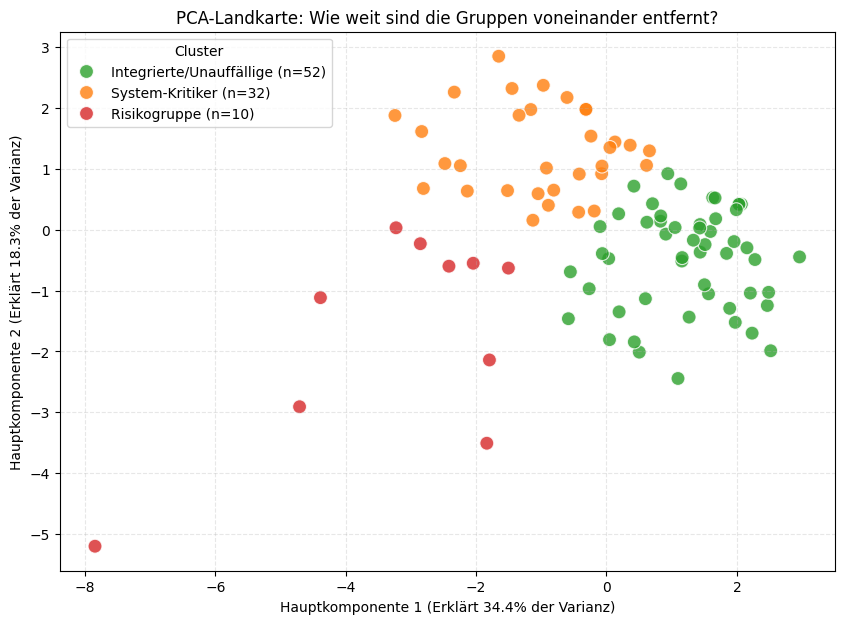

In [ ]:
# @title Zusatz: PCA-Visualisierung der Cluster (8.1/2)
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. PCA berechnen
pca = PCA(n_components=2)
# HIER LAG DER FEHLER: Wir nutzen 'X_scaled' statt 'df_scaled'
pca_components = pca.fit_transform(X_scaled)

# 2. DataFrame für den Plot bauen
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
# Wir übernehmen Ihre schönen Labels aus dem vorherigen Schritt
df_pca['Cluster'] = df['cluster_label']

# 3. Plotten
plt.figure(figsize=(10, 7))

# Wir nutzen exakt dieselben Farben wie in Ihrer Cluster-Grafik
custom_palette = {}
for label in df_pca['Cluster'].unique():
    if "Risiko" in str(label):
        custom_palette[label] = '#d62728' # Rot
    elif "Kritiker" in str(label):
        custom_palette[label] = '#ff7f0e' # Orange
    else:
        custom_palette[label] = '#2ca02c' # Grün

sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=df_pca,
    palette=custom_palette,
    s=100,
    alpha=0.8
)

# Beschriftung
var = pca.explained_variance_ratio_
plt.xlabel(f'Hauptkomponente 1 (Erklärt {var[0]:.1%} der Varianz)')
plt.ylabel(f'Hauptkomponente 2 (Erklärt {var[1]:.1%} der Varianz)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('img/chart_pca_clusters.png')
plt.close()

In [57]:
# @title Detail-Analyse ALLER Cluster (Profil-Plot) (8.2)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Definition der Analyse-Dimensionen
cols_to_analyze = {
    'safety_in_class': "Sicherheitsgefühl",
    'teacher_trust': "Vertrauen zu Lehrern",     # Wichtig für "Kritiker"-Gruppe
    'teacher_fairness': "Gerechtigkeit",
    'friends_in_class': "Freunde",
    'family_acceptance': "Rückhalt Familie",      # Wichtig für Risiko-Gruppe
    'physical_violence_freq': "Körperliche Gewalt",
    'verbal_violence_freq': "Verbale Gewalt"
}

# Mapping sicherstellen
freq_map_detail = {"Nie": 0, "Selten": 1, "Monatlich": 2, "Wöchentlich": 3, "Mehrmals pro Woche": 4, "Täglich": 5}
analysis_df = df.copy()
for col in cols_to_analyze:
    if analysis_df[col].dtype == 'object':
        analysis_df[col] = analysis_df[col].map(freq_map_detail).fillna(0)
    else:
        analysis_df[col] = analysis_df[col].fillna(0)

# 2. Daten für den Plot vorbereiten (Gruppiert nach Cluster)
# Wir berechnen den Mittelwert JEDES Clusters für JEDE Frage
cluster_means = analysis_df.groupby('cluster')[list(cols_to_analyze.keys())].mean()

# 3. Automatische Benennung der Cluster (für die Legende)
# Wir versuchen, den Clustern lesbare Namen zu geben basierend auf ihren Daten
cluster_labels = {}
for cid, row in cluster_means.iterrows():
    # Logik:
    # Viel Gewalt (>0.5) = "Risiko"
    # Wenig Gewalt + Wenig Lehrer-Vertrauen (<3.0) = "Kritiker"
    # Sonst = "Integrierte"
    victim_score = row['physical_violence_freq'] + row['verbal_violence_freq']
    trust_score = row['teacher_trust']
    
    if cid == risk_cluster_id:
        label = f"Risikogruppe (n={len(analysis_df[analysis_df['cluster']==cid])})"
    elif trust_score < 3.2 and victim_score < 1.0: # Schwelle für Kritiker
        label = f"System-Kritiker (n={len(analysis_df[analysis_df['cluster']==cid])})"
    else:
        label = f"Integrierte/Unauffällige (n={len(analysis_df[analysis_df['cluster']==cid])})"
    cluster_labels[cid] = label

# 4. Plotten (Multi-Line Chart)
plt.figure(figsize=(12, 7))

# Farben definieren (Risiko immer Rot, Rest dynamisch)
palette = sns.color_palette("deep", n_colors=len(cluster_means))
# Wir wollen, dass das Risikocluster rot ist. 
# Einfacher Hack: Wir plotten einfach Linien und setzen Farbe manuell.

for i, (cid, row) in enumerate(cluster_means.iterrows()):
    label = cluster_labels[cid]
    
    # Style-Logik
    if cid == risk_cluster_id:
        color = '#d62728' # Rot
        linewidth = 3
        zorder = 10 # Nach vorne
        marker = 'o'
    elif "Kritiker" in label:
        color = '#ff7f0e' # Orange
        linewidth = 2
        zorder = 5
        marker = 's'
    else:
        color = '#2ca02c' # Grün
        linewidth = 2
        zorder = 1
        marker = '^'

    plt.plot(
        range(len(cols_to_analyze)), 
        row, 
        marker=marker, 
        linewidth=linewidth, 
        color=color, 
        label=label,
        zorder=zorder
    )

    # Werte beschriften (nur bei Risiko und Kritikern, um Chaos zu vermeiden)
    if cid == risk_cluster_id or "Kritiker" in label:
        for idx, val in enumerate(row):
            plt.text(idx, val + 0.15, f"{val:.1f}", ha='center', color=color, fontweight='bold', fontsize=9)

# Finish Setup
plt.xticks(range(len(cols_to_analyze)), list(cols_to_analyze.values()), rotation=15)
plt.ylabel('Durchschnittlicher Score (0-5)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('img/chart_risk_profile.png')
plt.close()

In [58]:
# @title Radar-Chart der Risikogruppe (8.2/2)

from math import pi
import matplotlib.pyplot as plt

relevant_cols = list(cols_to_analyze.keys())

# 1. Calculate Mean for Risk Group
means_risk = analysis_df[analysis_df['cluster'] == risk_cluster_id][relevant_cols].mean()

# 2. Calculate Mean for the Rest (Comparison Group)
means_rest = analysis_df[analysis_df['cluster'] != risk_cluster_id][relevant_cols].mean()
# -------------------------------------

# 1. Prepare Data
categories = list(cols_to_analyze.values())
N = len(categories)

# Values (Close the loop by repeating the first value at the end)
values_risk = means_risk.tolist()
values_risk += values_risk[:1]

values_rest = means_rest.tolist()
values_rest += values_rest[:1]

# Calculate angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Start first axis at the top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Axis labels
plt.xticks(angles[:-1], categories)

# Y-Axis labels (keep small)
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=7)
plt.ylim(0, 5.5) # Assumption: Max Score is approx 5

# Plot Risk Group
ax.plot(angles, values_risk, linewidth=2, linestyle='solid', label='Risikogruppe', color='red')
ax.fill(angles, values_risk, 'red', alpha=0.25)

# Plot Average/Rest
ax.plot(angles, values_rest, linewidth=2, linestyle='solid', label='Durchschnitt (Rest)', color='blue')
ax.fill(angles, values_rest, 'blue', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.savefig('img/chart_risk_radar.png')
plt.close()

In [59]:
#@title Motives & Backgrounds: Perception vs. Self-Image: Calculations and Diagram (9)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Definition of options (Separated by question)
options_perception = {
    "money_material": "Geld oder materielle Dinge",
    "clothing": "Kleidung",
    "appearance": "Aussehen / Körperform",
    "behavior": "Verhalten",
    "rivalry": "Rivalität / Konkurrenz",
    "background_religion": "Herkunft / Religion / Hautfarbe",
    "other": "Anderes"
}

options_behavior = {
    "anger": "Aus Wut",
    "distress": "Aus Not",
    "fun": "Aus Spaß",
    "retaliation": "Weil ich selbst geärgert wurde",
    "other": "Sonstiges"
}

# 2. Evaluation: Perceived Motives (Q35)
counts_perception = {txt: 0 for txt in options_perception.values()}
n_perception = 0

# Filter only rows that contain an answer
valid_perception = df['bullying_motives_perception'].dropna()
n_perception = len(valid_perception)

for response in valid_perception:
    # Split at comma if multiple choice is present as string
    motives = [m.strip() for m in str(response).split(',')]
    for motive in motives:
        if motive in counts_perception:
            counts_perception[motive] += 1

# Percentage calculation Perception
percents_perception = {k: round((v / n_perception * 100), 1) if n_perception > 0 else 0 
                       for k, v in counts_perception.items()}

# 3. Evaluation: Own Motives (Perpetrator) (Q41)
counts_behavior = {txt: 0 for txt in options_behavior.values()}
n_behavior = 0

valid_behavior = df['reason_for_own_behavior'].dropna()
n_behavior = len(valid_behavior)

for response in valid_behavior:
    motives = [m.strip() for m in str(response).split(',')]
    for motive in motives:
        # Check against values here, as the CSV probably contains the text
        if motive in counts_behavior:
            counts_behavior[motive] += 1

# Percentage calculation Behavior
percents_behavior = {k: round((v / n_behavior * 100), 1) if n_behavior > 0 else 0 
                     for k, v in counts_behavior.items()}

# 4. Plotting (Two subplots side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# --- Plot 1: Perception ---
labels_1 = list(percents_perception.keys())
values_1 = list(percents_perception.values())
x_pos_1 = np.arange(len(labels_1)) # Create explicit positions

# Plot bars (use x_pos instead of labels for x-axis)
bars1 = ax1.bar(x_pos_1, values_1, color='lightblue', edgecolor='black')

ax1.set_title(f'Warum denkst du, mobben Schüler? (Wahrnehmung)\nn={n_perception}')
ax1.set_ylabel('Anteil der Befragten (%)')

# FIX: Set positions (Locator) first, then labels (Formatter)
ax1.set_xticks(x_pos_1)
ax1.set_xticklabels(labels_1, rotation=45, ha='right')

ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Write values above bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom')

# --- Plot 2: Perpetrator Statements ---
labels_2 = list(percents_behavior.keys())
values_2 = list(percents_behavior.values())
x_pos_2 = np.arange(len(labels_2)) # Create explicit positions

bars2 = ax2.bar(x_pos_2, values_2, color='lightcoral', edgecolor='black')

ax2.set_title(f'Warum hast du das getan? (Selbstauskunft Täter)\nn={n_behavior}')

# FIX: Set positions (Locator) first, then labels (Formatter)
ax2.set_xticks(x_pos_2)
ax2.set_xticklabels(labels_2, rotation=45, ha='right')

ax2.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/chart_motives_compare.png')
plt.close()

In [60]:
#@title Replace Placeholders in Template for Motives (9.1-9.2)

# Percentage Perpetrators
pct_perpetrators = round((n_behavior / num_total) * 100, 1) if num_total > 0 else 0
template = template.replace("{pct_perpetrators}", str(pct_perpetrators))

# Perceived motives top 2
sorted_perceived = sorted(percents_perception.items(), key=lambda x: x[1], reverse=True)
top_motive_perceived_1, pct_motive_perceived_1 = sorted_perceived[0]
top_motive_perceived_2, pct_motive_perceived_2 = sorted_perceived[1]
template = template.replace("{top_motive_perceived_1}", top_motive_perceived_1)
template = template.replace("{pct_motive_perceived_1}", str(pct_motive_perceived_1))
template = template.replace("{top_motive_perceived_2}", top_motive_perceived_2)
template = template.replace("{pct_motive_perceived_2}", str(pct_motive_perceived_2))

# Actual motives top 2
sorted_actual = sorted(percents_behavior.items(), key=lambda x: x[1], reverse=True)
top_motive_actual_1, pct_motive_actual_1 = sorted_actual[0]
top_motive_actual_2, pct_motive_actual_2 = sorted_actual[1]
template = template.replace("{top_motive_actual_1}", top_motive_actual_1)
template = template.replace("{pct_motive_actual_1}", str(pct_motive_actual_1))
template = template.replace("{top_motive_actual_2}", top_motive_actual_2)
template = template.replace("{pct_motive_actual_2}", str(pct_motive_actual_2))

In [61]:
#@title Trend-Analyse & Diagramme generieren (10)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aktuelle Daten in das gleiche Format bringen wie die Historie
# (Wir greifen auf die Variablen zu, die Sie im Notebook berechnet haben)
current_data_point = {
    "meta": {"school_year": school_year},
    "violence_prevalence_global": {
        "percent_physical_any": pct_physical_any,
        "percent_verbal_any": pct_verbal_any,
        "percent_cyber_any": pct_cyber_any
    },
    "climate_and_safety": {
        "percent_safety_high": pct_safety_high
    }
}

# 2. Liste kombinieren
all_years = history_data + [current_data_point]

# 3. Daten für Plot vorbereiten
trend_rows = []
for entry in all_years:
    sy = entry['meta']['school_year']
    v = entry.get('violence_prevalence_global', {})
    s = entry.get('climate_and_safety', {})
    
    trend_rows.append({
        "Schuljahr": sy,
        "Körperliche Gewalt": v.get('percent_physical_any', 0),
        "Verbale Gewalt": v.get('percent_verbal_any', 0),
        "Cybermobbing": v.get('percent_cyber_any', 0),
        "Hohes Sicherheitsgefühl": s.get('percent_safety_high', 0)
    })

df_trend = pd.DataFrame(trend_rows)

# Nach Schuljahr sortieren (wichtig!)
df_trend.sort_values('Schuljahr', inplace=True)

# --- Check: Haben wir genug Daten? ---
if len(df_trend) > 1:
    # A) Gewalt-Trend Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_trend['Schuljahr'], df_trend['Körperliche Gewalt'], marker='o', label='Körperlich')
    plt.plot(df_trend['Schuljahr'], df_trend['Verbale Gewalt'], marker='o', label='Verbal')
    plt.plot(df_trend['Schuljahr'], df_trend['Cybermobbing'], marker='o', label='Digital')
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.savefig('img/chart_trend_violence.png')
    plt.close()

    # B) Sicherheits-Trend Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df_trend['Schuljahr'], df_trend['Hohes Sicherheitsgefühl'], marker='s', color='green', linestyle='--')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig('img/chart_trend_safety.png')
    plt.close()
    
    # Texte generieren (einfacher Vergleich zum Vorjahr)
    # (Hier könnten Sie komplexe Logik einfügen, wir machen es simpel)
    last_year = df_trend.iloc[-2]
    this_year = df_trend.iloc[-1]
    
    def get_trend_text(old, new):
        diff = new - old
        if abs(diff) < 2: return "Unverändert"
        return f"{'Gestiegen' if diff > 0 else 'Gesunken'} ({diff:+.1f}%)"

    template = template.replace("{trend_text_phys}", get_trend_text(last_year['Körperliche Gewalt'], this_year['Körperliche Gewalt']))
    template = template.replace("{trend_text_verb}", get_trend_text(last_year['Verbale Gewalt'], this_year['Verbale Gewalt']))
    template = template.replace("{trend_text_cyber}", get_trend_text(last_year['Cybermobbing'], this_year['Cybermobbing']))

else:
    # Fallback: Nur 1 Jahr vorhanden
    print("Nicht genügend Daten für Trend-Analyse (nur 1 Jahr). Erzeuge leere Platzhalter.")
    plt.figure(); plt.text(0.5,0.5,"Keine Vorjahresdaten", ha='center'); plt.savefig('img/chart_trend_violence.png'); plt.close()
    plt.figure(); plt.text(0.5,0.5,"Keine Vorjahresdaten", ha='center'); plt.savefig('img/chart_trend_safety.png'); plt.close()
    
    template = template.replace("{trend_text_phys}", "Keine Vergleichsdaten")
    template = template.replace("{trend_text_verb}", "Keine Vergleichsdaten")
    template = template.replace("{trend_text_cyber}", "Keine Vergleichsdaten")

Nicht genügend Daten für Trend-Analyse (nur 1 Jahr). Erzeuge leere Platzhalter.


In [62]:
#@title Extract Free Text (Other) (A.1-A.4)

import re

# 1. Helper: Clean text to prevent LaTeX errors
def clean_text_for_report(text):
    if not isinstance(text, str): return ""
    # Escape characters that break LaTeX
    chars = {
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "_": r"\_",
        "#": r"\#",
        "{": r"\{",
        "}": r"\}",
        # We also replace double spaces that might occur after removing options
        "  ": " " 
    }
    for char, escaped in chars.items():
        text = text.replace(char, escaped)
    text = text.encode('latin-1', 'ignore').decode('latin-1')
    return text.strip()

# 2. Helper: Get standard options
def get_standard_options(survey_data, question_id):
    """Returns a list of the standard 'long' text options."""
    for q in survey_data:
        if q['short_id'] == question_id:
            if 'options' in q:
                opts = []
                for opt in q['options']:
                    if isinstance(opt, dict):
                        opts.append(opt['long'])
                    else:
                        opts.append(opt)
                return opts
    return []

# 3. Main Logic: Subtract options instead of splitting
def extract_freetext_answers(df, col_name, standard_options):
    if col_name not in df.columns:
        return "Keine Daten vorhanden."

    custom_answers = []
    
    # Sort options by length (longest first). 
    # This prevents partial removal (e.g. removing "Male" from "Malevolent")
    # and ensures precise matching.
    sorted_options = sorted(standard_options, key=len, reverse=True)
    
    # Common labels for "Other" that usually precede the text in CSVs
    # We remove these labels to clean up the result.
    remove_labels = ["Anderes", "Sonstiges", "Other", "nan", "None", "Eigenes", "Begründung"]

    for entry in df[col_name].dropna():
        # Work with a fresh string copy
        text = str(entry)
        
        # A. REMOVE STANDARD OPTIONS
        # We iterate through every possible checkbox answer for this question
        # and remove it from the student's answer string.
        for opt in sorted_options:
            if opt in text:
                text = text.replace(opt, "")

        # B. CLEANUP ARTIFACTS
        # 1. Remove the "Other" labels (case insensitive)
        for label in remove_labels:
            # We use regex to match whole words to avoid removing parts of user words
            pattern = re.compile(re.escape(label), re.IGNORECASE)
            text = pattern.sub("", text)

        # 2. Cleanup leftover commas and whitespace
        # (e.g., "Option A, , My Text" becomes ", , My Text")
        text = text.replace(r",", " ") # Replace remaining commas with spaces to treat them as separators
        text = re.sub(r'\s+', ' ', text) # Merge multiple spaces into one
        text = text.strip() # Remove start/end whitespace

        # 3. Final Check
        # If the user typed a comma in their sentence, it is preserved (mostly),
        # but since we replaced commas with spaces in step B2 to clean up the CSV structure, 
        # we might lose grammatical commas. 
        # BETTER APPROACH FOR B2:
        # Instead of replacing commas blindly, let's just strip leading non-alphanumeric chars.
        
        # Reset text from raw entry for a second pass with better logic:
        text = str(entry)
        for opt in sorted_options:
            # Replace option with a unique placeholder that isn't a comma
            text = text.replace(opt, "")
            
        # Remove labels
        for label in remove_labels:
            text = text.replace(label, "")
            
        # Now we likely have strings like: ", , , I felt sad, because..."
        # We use regex to remove leading/trailing punctuation (commas, spaces)
        # ^[ ,;]+ matches commas or spaces at the START
        text = re.sub(r'^[ ,;]+', '', text)
        # [ ,;]+$ matches commas or spaces at the END
        text = re.sub(r'[ ,;]+$', '', text)
        
        # If anything substantial is left (longer than 2 chars), it's a custom answer
        if len(text) > 2:
            cleaned = clean_text_for_report(text)
            custom_answers.append(cleaned)

    if not custom_answers:
        return "Keine Einträge."

    # Deduplicate entries while keeping order
    seen = set()
    unique_answers = []
    for ans in custom_answers:
        if ans not in seen:
            unique_answers.append(ans)
            seen.add(ans)

    return "\n    * ".join(unique_answers)

# 4. Map Template Placeholders
mappings = [
    ("{list_free_text_q16}", "physical_violence_type"),
    ("{list_free_text_q19}", "verbal_violence_type"),
    ("{list_free_text_q22}", "cyberbullying_type"),
    ("{list_free_text_q26}", "defense_reaction"),
    ("{list_free_text_q31}", "observer_feelings"), 
    ("{list_free_text_q32}", "past_reaction_observation"),
    ("{list_free_text_q28}", "bullying_location"),
    ("{list_free_text_q34}", "preferred_help_contact"),
    ("{list_free_text_q35}", "bullying_motives_perception"),
    ("{list_free_text_q41}", "reason_for_own_behavior"),
]

# 5. Execute Replacement
for template_key, col_name in mappings:
    # Get standard options
    std_opts = get_standard_options(survey, col_name)
    
    # Extract custom text
    result_text = extract_freetext_answers(df, col_name, std_opts)
    
    # Replace in template
    template = template.replace(template_key, result_text)

print("✅ Freitexte (verbessert) erfolgreich extrahiert.")

✅ Freitexte (verbessert) erfolgreich extrahiert.


In [63]:
#@title Free Text: Generate LaTeX Table and Replace in Template (A.5)

import pandas as pd

# 1. Prepare Data
open_texts = df[['class_level', 'open_feedback_text']].dropna().copy()

# Sort logic
open_texts['sort_num'] = open_texts['class_level'].str.extract(r'(\d+)').astype(int)
open_texts = open_texts.sort_values(by='sort_num')

# 2. SANITIZE TEXT (Crucial for LaTeX)
# LaTeX crashes if text contains & % $ _ without a backslash.
def clean_for_latex(text):
    if not isinstance(text, str): return ""
    chars = {
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "_": r"\_",
        "#": r"\#",
        "{": r"\{",
        "}": r"\}",
        "\n": " " # Convert newlines to spaces to prevent table breaks
    }
    for char, escaped in chars.items():
        text = text.replace(char, escaped)
    return text

# Apply cleaning
open_texts['class_level'] = open_texts['class_level'].apply(clean_for_latex)
open_texts['open_feedback_text'] = open_texts['open_feedback_text'].apply(clean_for_latex)

# 3. Manually Build the LaTeX String
# We use 'longtable' for page breaks.
# {|p{2cm}|p{12cm}|} defines vertical lines (|) and wrapped text width (p{...}).
latex_rows = []

# Start of table
latex_rows.append(r"```{=latex}")  # RAW BLOCK START (Tells Pandoc: This is code, don't escape it!)
latex_rows.append(r"\begin{longtable}{|p{2.5cm}|p{12cm}|}") 
latex_rows.append(r"\hline")
latex_rows.append(r"\textbf{Klasse} & \textbf{Freitext-Antwort} \\ \hline") # Header

# Loop through data to add rows
for _, row in open_texts.iterrows():
    # formatting: col1 & col2 \\ \hline
    line = f"{row['class_level']} & {row['open_feedback_text']} \\\\ \\hline"
    latex_rows.append(line)

# End of table
latex_rows.append(r"\end{longtable}")
latex_rows.append(r"```") # RAW BLOCK END

# Join it all together
final_latex_table = "\n".join(latex_rows)

template = template.replace("{open_text}", final_latex_table)

In [64]:
#@title Free Text: Generate Cleaned Wordcloud (A.6)

if IN_COLAB:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    import spacy
    import pandas as pd

    # 2. Setup Spacy Model
    try:
        nlp = spacy.load("de_core_news_sm")
    except OSError:
        print("Downloading German model...")
        from spacy.cli import download
        download("de_core_news_sm")
        nlp = spacy.load("de_core_news_sm")

    # 3. Define Stopwords
    # Merge default stopwords with school-specific noise words
    stop_words = nlp.Defaults.stop_words.union({
        "dass", "muss", "soll", "immer", "mal", "schon", "wäre", "würde", "halt",
        "nein", "ja", "alles", "nichts", "wegen", "beim", "vom", "ganzen",
        "finde", "fände", "gut", "schlecht", # Evaluative words often clutter clouds
        "schule", "klasse" # Context words usually not needed in the cloud
    })

    def generate_clean_wordcloud(text_list):
        """
        Generates a cleaned wordcloud from a list of strings using Spacy lemmatization.
        """
        # Join all texts
        full_text = " ".join([str(t) for t in text_list])
        
        # Increase max_length if you have huge datasets (optional)
        nlp.max_length = 2000000 
        
        # NLP Processing
        doc = nlp(full_text)
        
        cleaned_tokens = []
        for token in doc:
            # Filter: Stopwords, Punctuation, Whitespace
            if not token.is_stop and not token.is_punct and not token.is_space:
                # Check custom stopwords list
                if token.text.lower() not in stop_words:
                    # Filter by Part-of-Speech: Keep Nouns, Verbs, Adjectives
                    if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PROPN']:
                        cleaned_tokens.append(token.lemma_)

        cleaned_text = " ".join(cleaned_tokens)

        if not cleaned_text:
            print("Nach der Filterung sind keine Wörter übrig geblieben.")
            return

        # Generate Cloud
        wordcloud = WordCloud(
            width=1600, 
            height=800,
            background_color="white",
            colormap="viridis",
            max_words=80,
            collocations=False, # Avoids repeating phrases like "good school" as "good school" and "school"
            min_word_length=3
        ).generate(cleaned_text)

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout(pad=0)
        
        # Save output
        plt.savefig("img/wordcloud_feedback.png")
        plt.close()

    raw_text_list = df.loc[open_texts.index, 'open_feedback_text'].dropna().tolist()

    # Option B: Fallback (If 'df' is not available)
    # If you only have 'open_texts', we must remove the LaTeX escape characters manually.
    # raw_text_list = open_texts['open_feedback_text'].str.replace(r'\\', '', regex=True).tolist()

    # Generate the Cloud
    generate_clean_wordcloud(raw_text_list)

In [65]:
#@title Placeholder if wordcloud generation is skipped (A.6/2)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

if not os.path.exists("img/wordcloud_feedback.png"):
    # 1. Setup the figure
    # Aspect ratio matches a typical wordcloud (wide)
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
    
    # Set limits to make drawing easier (coordinates 0 to 1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off') # Hide the square box border

    # 2. Define the Cloud Shape (Cluster of circles)
    # We use a light grey color for the cloud body
    cloud_color = '#ecf0f1'
    
    # Coordinates (x, y) and radius (r) for the "fluffs"
    fluffs = [
        (0.50, 0.50, 0.25), # Center Body
        (0.35, 0.50, 0.20), # Left Lobe
        (0.65, 0.50, 0.20), # Right Lobe
        (0.42, 0.65, 0.18), # Top Left
        (0.58, 0.65, 0.18), # Top Right
    ]

    for x, y, r in fluffs:
        circle = patches.Circle((x, y), r, color=cloud_color, zorder=1)
        ax.add_patch(circle)

    # 3. Draw the Sad Face
    # Eyes (Small dark circles)
    eye_left = patches.Circle((0.45, 0.55), 0.015, color='#7f8c8d', zorder=2)
    eye_right = patches.Circle((0.55, 0.55), 0.015, color='#7f8c8d', zorder=2)
    ax.add_patch(eye_left)
    ax.add_patch(eye_right)

    # Mouth (A curved line for a frown)
    # We create a simple arc using a plotted line
    x_mouth = np.linspace(0.46, 0.54, 50)
    # Parabola equation for a frown: y = -a*(x-h)^2 + k
    y_mouth = -1.5 * (x_mouth - 0.5)**2 + 0.50 
    
    ax.plot(x_mouth, y_mouth, color='#7f8c8d', linewidth=2, zorder=2)

    # 4. Add the Text below the cloud
    plt.text(
        0.5, 0.15, 
        "Die Generierung der Wortwolke \nist nicht verfügbar.", 
        ha='center', 
        va='center', 
        fontsize=14, 
        color='#95a5a6', 
        fontweight='bold',
        fontname='sans-serif'
    )

    # 5. Save
    plt.savefig("img/wordcloud_feedback.png", bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [66]:
#@title Feedback-Analyse, Diagramm & Text (inkl. Freitext)
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import numpy as np

feedback_section_md = ""

if has_feedback:
    # -----------------------------------------------------------
    # 1. Datenvorbereitung (Quantitativ)
    # -----------------------------------------------------------
    questions_map = {
        'Die Fragen waren klar und verständlich formuliert.': 'Verständlichkeit',
        'Ich habe mich beim Beantworten sicher und anonym gefühlt.': 'Sicherheitsgefühl',
        'Die angegebene Zeit (10 bis 20 Min.) war realistisch und hat für mich gepasst.': 'Zeitaufwand',
        'Wie würdest du die Umsetzung des Fragebogens bewerten?': 'Gesamtumsetzung',
        'Ich glaube, dass die Ergebnisse dieser Umfrage etwas an unserer Schule verbessern werden.': 'Glaube an Wirkung'
    }
    
    # Sicherstellen, dass Daten numerisch sind
    for col in questions_map.keys():
        if col in df_feedback.columns:
            df_feedback[col] = pd.to_numeric(df_feedback[col], errors='coerce')

    n_feedback = len(df_feedback)

    # Kennzahlen für Text
    col_impact = 'Ich glaube, dass die Ergebnisse dieser Umfrage etwas an unserer Schule verbessern werden.'
    mean_understanding = round(df_feedback['Die Fragen waren klar und verständlich formuliert.'].mean(), 1)
    mean_safety = round(df_feedback['Ich habe mich beim Beantworten sicher und anonym gefühlt.'].mean(), 1)
    mean_impact = round(df_feedback[col_impact].mean(), 1)
    
    # Schutz vor Division durch Null, falls n_feedback sehr klein ist
    if n_feedback > 0:
        pct_skeptical = round(len(df_feedback[df_feedback[col_impact] <= 2]) / n_feedback * 100, 1)
    else:
        pct_skeptical = 0.0

    # -----------------------------------------------------------
    # 2. Diagramm erstellen (Diverging Bar Chart)
    # -----------------------------------------------------------
    category_counts = []
    labels = []

    for q_long, q_short in questions_map.items():
        if q_long in df_feedback.columns:
            counts = df_feedback[q_long].value_counts(normalize=True) * 100
            neg = counts[counts.index.isin([1, 2])].sum()
            neu = counts[counts.index.isin([3])].sum()
            pos = counts[counts.index.isin([4, 5])].sum()
            category_counts.append([neg, neu, pos])
            labels.append(q_short)

    if category_counts:
        df_plot = pd.DataFrame(category_counts, columns=['Negativ (1-2)', 'Neutral (3)', 'Positiv (4-5)'], index=labels)

        fig, ax = plt.subplots(figsize=(10, 5))
        df_plot.plot(kind='barh', stacked=True, color=['#e74c3c', '#f1c40f', '#2ecc71'], ax=ax, edgecolor='white')
        
        plt.xlabel('Anteil der Antworten (%)')
        plt.xlim(0, 100)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        
        for c in ax.containers:
            ax.bar_label(c, fmt='%.0f%%', label_type='center', color='black', fontsize=9)

        plt.tight_layout()
        plt.savefig('img/chart_feedback_overview.png', dpi=150)
        plt.close()
    else:
        # Fallback, falls keine Daten vorhanden
        plt.figure()
        plt.text(0.5, 0.5, 'Keine Feedback-Daten', ha='center')
        plt.savefig('img/chart_feedback_overview.png')
        plt.close()

    # -----------------------------------------------------------
    # 3. Dynamische Text-Logik (Quantitativ)
    # -----------------------------------------------------------
    # A) Prozess (B.1)
    if mean_understanding >= 4.0 and mean_safety >= 4.0:
        interp_b1 = "Die überwiegend positiven Werte (grüne Balken) bestätigen, dass die Erhebung verstanden wurde und das Sicherheitsgefühl hoch war."
    else:
        interp_b1 = "Die Bewertungen zeigen ein gemischtes Bild."

    # B) Vertrauen (B.2)
    if pct_skeptical >= 30.0:
        label_b2 = "Herausforderung"
        text_b2 = f"Der Balken für 'Glaube an Wirkung' zeigt einen deutlichen Rot-Anteil: {pct_skeptical} % der Befragten sind aktuell skeptisch."
        recommendation_b2 = "Sichtbare Folgemaßnahmen sind essenziell, um diesen Balken in Zukunft ins Grüne zu verschieben."
    elif pct_skeptical <= 15.0:
        label_b2 = "Positives Signal"
        text_b2 = f"Auch beim 'Glauben an Wirkung' überwiegt der grüne Anteil. Nur {pct_skeptical} % äußern Zweifel."
        recommendation_b2 = "Eine gute Basis für die weitere Arbeit."
    else:
        label_b2 = "Geteiltes Meinungsbild"
        text_b2 = f"Während Technik und Sicherheit top bewertet werden, ist die Erwartungshaltung an die Folgen gemischt ({pct_skeptical} % Skeptiker)."
        recommendation_b2 = "Transparenz ist nun entscheidend."

    # -----------------------------------------------------------
    # 4. Freitext-Antworten verarbeiten (NEU)
    # -----------------------------------------------------------
    col_open_feedback = "Offenes Feedback zum Fragebogen" # Spaltennamen ggf. anpassen
    open_feedback_md = ""

    if col_open_feedback in df_feedback.columns:
        # Leere Einträge entfernen
        comments = df_feedback[col_open_feedback].dropna().astype(str)
        # Nur Einträge behalten, die länger als 3 Zeichen sind (um "Nein" oder "-" zu filtern)
        comments = [c for c in comments if len(c.strip()) > 3 and c.lower() not in ['nein', 'nichts', 'no', '-']]
        
        if comments:
            open_feedback_md = "## C.3 Offenes Feedback (O-Töne)\n"
            open_feedback_md += "Zusätzlich zur Bewertung wurden folgende Kommentare hinterlassen:\n\n"
            for comment in comments:
                # Zeilenumbrüche im Kommentar durch Leerzeichen ersetzen für sauberes Markdown
                clean_comment = comment.replace('\n', ' ')
                open_feedback_md += f"> \"{clean_comment}\"\n\n"
        else:
            open_feedback_md = "## C.3 Offenes Feedback\nEs wurden keine spezifischen Textkommentare hinterlassen.\n"

    # -----------------------------------------------------------
    # 5. Markdown zusammensetzen
    # -----------------------------------------------------------
    feedback_section_md = f"""
# Anhang C: Meta-Evaluation (Qualitätssicherung)

Um die Qualität der Daten und das Vertrauen der Schülerschaft sicherzustellen, wurde im Anschluss an die Hauptumfrage eine separate Evaluation durchgeführt (n={n_feedback}).

![Detailliertes Meinungsbild zur Umfrage](img/chart_feedback_overview.png)

## C.1 Bewertung des Prozesses
Die Schülerinnen und Schüler bewerteten die technische und inhaltliche Umsetzung sehr differenziert:

* **Verständlichkeit:** {mean_understanding} / 5
* **Gefühlte Sicherheit & Anonymität:** {mean_safety} / 5

**Einordnung:** {interp_b1}

## C.2 Vertrauen in Konsequenzen
Auf die Frage *"{col_impact}"* liegt der Durchschnittswert bei **{mean_impact} / 5**.

* **{label_b2}:** {text_b2}
* **Fazit:** {recommendation_b2}

{open_feedback_md}
"""

else:
    feedback_section_md = ""

template = template.replace("{feedback_section_placeholder}", feedback_section_md)

In [67]:
#@title AI Abstract Generation (Optional)

if IN_COLAB:
    from google.colab import ai

    # Prepare the prompt
    prompt = f"""
You are an expert educational data analyst summarizing a school report.

YOUR TASK:
Write a concise "Abstract" in German (max. 4 sentences).
1. State clearly what this document is (Statusbericht based on n=... students).
2. Mention the single most defining trend or conflict found in the data (e.g., the discrepancy between teacher perception and student reality).
3. Do not list detailed statistics. Keep it high-level.

FORMATTING:
- Use standard Markdown.
- One single paragraph.
- No bullet points.
- Objective, professional tone.

HERE IS THE REPORT CONTENT:
{template}
    """

    # Generate the summary
    summary = ai.generate_text(
        prompt,
    )

    md_summary = f"""
# Zusammenfassung (KI-gestützt)
**Wichtiger Hinweis**: *Der folgende Abschnitt wurde automatisch durch ein LLM (Large Language Model) generiert. Es kann zu Missinterpretationen oder Fehlern kommen.*

{summary}

"""
    
    print(f"Möchten Sie die folgende KI-generierte Zusammenfassung in den Bericht einfügen?\n\n{md_summary}")

    own_text = input("Geben Sie 'j' ein, um zu bestätigen, drücken Sie ENTER zum überspringen oder fügen Sie Ihren Text ein (Markdown): ")

    if own_text.lower() == 'j':
        # Insert the summary into the template
        template = template.replace("{ai_abstract_section}", md_summary)

    else:
        # User provided their own text
        template = template.replace("{ai_abstract_section}", own_text)


else:
    template = template.replace("{ai_abstract_section}", "")


In [ ]:
#@title AI Executive Summary Generation (Optional)

if IN_COLAB:
    from google.colab import ai

    # Prepare the prompt
    prompt = f"""
You are a strategic consultant for school administration. You are provided with the raw content of a school report.

YOUR TASK:
Write a high-impact "Executive Summary" in German.
1. Do NOT repeat the general study metadata (participant count, etc.) unless absolutely necessary for context.
2. Focus on "Strategic Insights": Synthesize the data to highlight the biggest gaps (e.g., specific risk groups, dangerous locations, teacher blind spots).
3. Connect findings to implications: Don't just say "38% violence"; explain that this indicates a systemic issue in specific grades.
4. Conclude with a "Call to Action" summarizing the direction for the school management.

FORMATTING:
- Use standard Markdown.
- No Title.
- Structure exactly into these 3 subheadings (##):
  ## Kernergebnisse & Risikolage
  (Use bullet points here for the hardest facts/correlations)
  ## Strategische Defizite
  (Focus on what is missing, e.g., teacher intervention perception)
  ## Priorisierte Handlungsfelder
  (Synthesize the recommended next steps)
- You have to always add a blank line between text and bullet points for proper Markdown rendering.

HERE IS THE REPORT CONTENT:
{template}
    """

    # Generate the summary
    summary = ai.generate_text(
        prompt,
    )

    md_summary = f"""
# Entscheidungsorientierte Zusammenfassung (KI-gestützt)
**Wichtiger Hinweis**: *Der folgende Abschnitt wurde automatisch durch ein LLM (Large Language Model) generiert. Es kann zu Missinterpretationen oder Fehlern kommen.*

{summary}

"""
    
    print(f"Möchten Sie die folgende AI Executive Summary in den Bericht einfügen?\n\n{md_summary}")
    own_text = input("Geben Sie 'j' ein, um zu bestätigen, drücken Sie ENTER zum überspringen oder fügen Sie Ihren Text ein (Markdown): ")

    if own_text.lower() == 'j':
        # Insert the summary into the template
        template = template.replace("{ai_executive_summary}", md_summary)

    else:
        template = template.replace("{ai_executive_summary}", own_text)



else:
    template = template.replace("{ai_executive_summary}", "")


In [69]:
#@title Convert Markdown to PDF with Pandoc

import pypandoc

# You must specify the output filename and the format
safe_school_year = school_year.replace("/", "-")
output_filename = f"Auswertung_Ergebnisse_{safe_school_year}.pdf"

try:
    pypandoc.convert_text(
        template,
        'pdf',
        format='md',
        outputfile=output_filename,
        extra_args=['--pdf-engine=xelatex']  # <--- THIS IS THE FIX
    )
    print(f"Success! Saved to {output_filename}")
except OSError as e:
    print("Error: Pandoc not found. Please ensure Pandoc is installed on your system.")
except RuntimeError as e:
    print(f"Conversion Error: {e}")

Success! Saved to Auswertung_Ergebnisse_2025-2026.pdf


In [70]:
#@title Save PDF with CUMULATIVE History (Master Archive)

import json
import os
import pandas as pd

# Hilfsfunktion: Pandas Series/DataFrame in dict umwandeln, falls vorhanden
def serialize_pandas(obj):
    if isinstance(obj, (pd.Series, pd.DataFrame)):
        return json.loads(obj.to_json(orient='index'))
    return str(obj)

# 1. Sammeln aller Metriken (Erweitert um Granulardaten)
calculation_dump = {
    "meta": {
        "author": author_name,
        "school_year": school_year,
        "report_date": date_today,
        "student_count_input": student_count,
        "n_total_responses": num_total,
        "response_rate_percent": response_rate,
        "data_collection_period": data_collection_period,
        "class_levels_range": f"{min_class_level} - {max_class_level}"
    },
    "demographics_detailed": {
        "total_by_gender": {
            "percent_female": pct_female,
            "percent_male": pct_male,
            "percent_diverse": pct_diverse
        },
        # Speichert Verteilung pro Klasse (aus Cell 149)
        "distribution_per_grade": serialize_pandas(demographics) 
    },
    "climate_and_safety": {
        "percent_safety_high": pct_safety_high,
        "percent_friends_low": pct_friends_low,
        "mean_teacher_justice": mean_teacher_justice,
        "mean_teacher_trust": mean_teacher_trust,
        "mean_teacher_care": mean_teacher_serious,
        "std_teacher_justice": round(df['teacher_fairness'].std(), 2),
        "std_teacher_trust": round(df['teacher_trust'].std(), 2),
        "std_safety": round(df['safety_in_class'].std(), 2)
    },
    "violence_prevalence_global": {
        "percent_verbal_any": pct_verbal_any,
        "percent_physical_any": pct_physical_any,
        "percent_cyber_any": pct_cyber_any,
        "percent_chronic": pct_chronic,
        "peak_violence_class": peak_violence_class
    },
    
    "violence_by_gender": serialize_pandas(
        df.groupby('gender')[['physical_violence_freq', 'verbal_violence_freq', 'cyberbullying_freq']].apply(
            lambda x: pd.Series({
                'physical': compute_violence_prevalence(pd.DataFrame(x), 'physical_violence_freq'),
                'verbal': compute_violence_prevalence(pd.DataFrame(x), 'verbal_violence_freq'),
                'cyber': compute_violence_prevalence(pd.DataFrame(x), 'cyberbullying_freq')
            })
        )
    ),
    "context": {
        "n_incidents_reported": n_incidents,
        "top_locations": {
            top_location_1: count_loc_1,
            top_location_2: count_loc_2
        },
        "percent_internal_perpetrators": pct_internal_perpetrators,
        "percent_group_bullying": pct_group_bullying
    },
    "risk_groups": {
        "percent_bully_victims": pct_bully_victims,
        "n_risk_cluster": n_risk_cluster,
        "percent_risk_cluster": pct_risk_cluster,
        },
    "motives": {
        "perceived_top_2": {
            top_motive_perceived_1: pct_motive_perceived_1,
            top_motive_perceived_2: pct_motive_perceived_2
        },
        "actual_top_2": {
            top_motive_actual_1: pct_motive_actual_1,
            top_motive_actual_2: pct_motive_actual_2
        }
    }
}

final_archive = history_data + [calculation_dump] 

# 2. JSON Encoding
json_bytes = json.dumps(final_archive, ensure_ascii=False).encode('utf-8')

# 3. An PDF anhängen
if os.path.exists(output_filename):
    with open(output_filename, 'ab') as f:
        f.write(b'\n') 
        f.write(json_bytes)
    print(f"✅ Master-Archiv erstellt! ({len(final_archive)} Jahrgänge enthalten).")
    print(f"Datei: {output_filename}")
else:
    print("Fehler: PDF nicht gefunden.")

✅ Master-Archiv erstellt! (1 Jahrgänge enthalten).
Datei: Auswertung_Ergebnisse_2025-2026.pdf


In [71]:
#@title Download File (Colab only)

if IN_COLAB:
    from google.colab import files
    print(f"Starte Download von {output_filename}...")
    files.download(output_filename)
else:
    print(f"Die Datei wurde lokal gespeichert unter: {os.path.abspath(output_filename)}")

Die Datei wurde lokal gespeichert unter: /home/johangrims/P/P/Mobbing/Auswertung_Ergebnisse_2025-2026.pdf
